In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing and importing the packages needed

In [ ]:
#installing the packages if needed
%%capture
!pip install -U scikit-learn
!pip install langdetect
!pip install swifter
!pip install -U deep_translator
!pip install emoji
!pip install wordcloud
!pip install spacy
!pip install vaderSentiment
!pip install advertools
!pip install jieba
!pip install textblob

In [ ]:
#importing the packages
%%capture
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from langdetect import detect
import swifter
from deep_translator import GoogleTranslator
import emoji
from emoji import UNICODE_EMOJI
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download(["names","vader_lexicon"])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
import string
import spacy
nlp = spacy.load('en_core_web_sm')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import advertools as adv
import jieba.posseg as pseg
import jieba
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

## 0.Introduction 

There are six parts to this analysis. 

In **part 1**, we will import the data and combine the datasets, followed by data preprocessing in **part 2**. 

In **part 3**, we will experiment with language detection using a small slice of dataset first to see how many languages there potentially are in which the reviews are written. Then using the Chinese reviews in this small dataset, we will develop an extended list of key words. Finally using the keywords provided and developed, we will filter the reviews and identify those that are about localisation. 

In **part 4**, using approximately 15% of the total data about localisation, we will examine the positive and negative reviews, try fitting a logistic regression model to reveal the most descriminating words, as well as an inbuilt sentiment analyzer to further study the relationship between user scores and detected sentiment. 

In **part 5**, we will take a look at the games that have the most localisation requests, as well as the top languages in which these requests were made, both in positive and negative reviews. 

In **part 6**, we will use all the negative localisation reviews to examine the reasons for users' negative sentiment. **Part 7** will provide a conclusion to the report. 

NOTE: At the end of each section, the processed dataset has been exported to csv, considering the time it would take to go through the process again. At the start of each section, codes to read datasets into the report are provided again, in case they are needed. 

## 1.Data importing

In this part, we import the reviews data and the stats data first, and then combine the reviews data into one dataset and check that against the stats information. 

In [ ]:
#setting the paths for all three files
path_review_1 = 'drive/MyDrive/data/REVIEWS_1.xlsx'
path_review_2 = 'drive/MyDrive/data/REVIEWS_2.xlsx'
path_stats = 'drive/MyDrive/data/!stats.xlsx'
path_keywords = 'drive/MyDrive/data/Keywords.xlsx'

In [ ]:
#reading reviews_1 all sheets
reviews_1_all_sheets = pd.read_excel(path_review_1, sheet_name=None)

In [ ]:
#reviews_1 all sheets have consistent column names, ready to concact
reviews_1_all_sheets['p1'].head()

,ID,Score/Recommendation,Text
0,title777,4,"Velmi návyková hra, skvěle zpracovaná. Jen ško..."
1,title777,4,"Hra hezká, vadí mi, že třeba přes noc se nepln..."
2,title777,5,Cool
3,title777,5,Suprová hra.
4,title777,5,"⚽️🏀🏈⚾️🥎去浏览器打开📲87ṚмＢ,C☻м📲华人最大娱乐站，开户免费送现金100块‼️-..."


One thing we could notice for now is the 'ID' column contains 'title', making it a column of 'object', which takes more space than if it were integers. We will change this later. 

In [ ]:
reviews_1 = pd.concat(reviews_1_all_sheets, ignore_index=True)

In [ ]:
reviews_1.shape

(5708750, 3)

In [ ]:
#getting all sheets from the second dataset.
reviews_2_all_sheets = pd.read_excel(path_review_2, sheet_name=None)

In [ ]:
#checking the data brings to our attention that 
#p11 and p13 in reviews_2 have different column names. Let's change that
reviews_2_all_sheets['p11'].columns = ['ID', 'Score/Recommendation', 'Text']
reviews_2_all_sheets['p13'].columns = ['ID', 'Score/Recommendation', 'Text']

In [ ]:
#now we can concact
reviews_2 = pd.concat(reviews_2_all_sheets, ignore_index=True)
reviews_2.shape

(6469363, 3)

In [ ]:
reviews_2.shape

(6469363, 3)

In [ ]:
#combine both files
reviews = pd.concat([reviews_1, reviews_2], axis=0)

In [ ]:
#check shape
reviews.shape

(12178113, 3)

In [ ]:
#check first 5 rows
with pd.option_context('display.max_colwidth', -1): 
  display(reviews.head())


,ID,Score/Recommendation,Text
0,title777,4,"Velmi návyková hra, skvěle zpracovaná. Jen škoda, že se neplní kanystry rychleji. Je to zbytečně zdlouhavé. Proto jedna hvězda dolů."
1,title777,4,"Hra hezká, vadí mi, že třeba přes noc se neplní kanystry a pak nemůžu přes den hrát a pořád čekám..."
2,title777,5,Cool
3,title777,5,Suprová hra.
4,title777,5,"⚽️🏀🏈⚾️🥎去浏览器打开📲87ṚмＢ,C☻м📲华人最大娱乐站，开户免费送现金100块‼️--国际监管，安全无忧*真人视讯，百家乐，体育投注-电竞投注，百款真人美女视讯游戏，捕鱼，老虎机*棋牌，彩票*电子，全球各种赛事免费直播，‼️多种游戏免费玩，全新游戏玩法，体验无穷乐趣➤⚽️🏀全球各种赛事免费直播，🏈⚾️🥎"


Row 5 looks like a spam. We will just keep that in mind for now.

In [ ]:
#need to check if data shape is consistent with data information using !stats file
info_all = pd.read_excel(path_stats, sheet_name=None)

In [ ]:
#Checking how many sheets
info_all.keys()

dict_keys(['PC', 'Mobile'])

In [ ]:
#Checking dataframe 
info_all['PC'].head()

,ID,n in file1,n in file2,total,Unnamed: 4,Unnamed: 5,Text reviews of PC titles are generally larger and may cost more resources.
0,title1,0,1017,1017,NaN,NaN,NaN
1,title103,0,116,116,NaN,NaN,NaN
2,title106,0,1687,1687,NaN,NaN,NaN
3,title11,291,0,291,NaN,NaN,NaN
4,title118,0,9481,9481,NaN,NaN,NaN


In [ ]:
#checking to see if we need to clean up the two sheets
info_all['Mobile'].isnull().sum()


ID                                                                                                       0
n in file1                                                                                               0
n in file2                                                                                               0
total                                                                                                    0
Unnamed: 4                                                                                             625
Unnamed: 5                                                                                             625
Text reviews of Mobile titles are generally smaller compared to PC reviews and cost less resources.    623
dtype: int64

The unamed columns contain all NA values. The last column contains all NA columns except two rows. Let's check that. 

In [ ]:
info_all['PC'].isnull().sum()

ID                                                                               0
n in file1                                                                       0
n in file2                                                                       0
total                                                                            0
Unnamed: 4                                                                     283
Unnamed: 5                                                                     283
Text reviews of PC titles are generally larger and may cost more resources.    281
dtype: int64

In [ ]:
#checking the two notna rows in the last column
info_all['PC'][info_all['PC']['Text reviews of PC titles are generally larger and may cost more resources.'].notnull()]

,ID,n in file1,n in file2,total,Unnamed: 4,Unnamed: 5,Text reviews of PC titles are generally larger and may cost more resources.
5,title126,0,13733,13733,NaN,NaN,Total PC reviews:
6,title14,0,19,19,NaN,NaN,1603803


In [ ]:
#given last column is summary data we can easily get, let's drop it to clean up
info_mobile = info_all['Mobile'].drop(info_all['Mobile'].columns[[4, 5, 6]], axis=1)

In [ ]:
#do the same with pc file
info_pc = info_all['PC'].drop(info_all['PC'].columns[[4,5,6]],axis=1)

In [ ]:
#calculating total rows for each file 
total_mobile = info_mobile['total'].sum()

In [ ]:
total_pc = info_pc['total'].sum()

In [ ]:
#getting the total number of records from the stats file
total_mobile+total_pc

12178113

In [ ]:
reviews.shape[0]

12176439

Good! The reviews data shape matches the data information! Now we have one reviews dataset and two info dataset! 

## 2.Data preprocessing

To preprocess the data, we will doing the following:

*   change the column names to be consistent with naming conventions 
*   check NA values 
*   remove spam rows
*   clean up the game ID column
*   unify the 'score_recommendation' column
*   export prepocessed data to csv for later convenience. 

In [ ]:
#changing column names to lower case. 
reviews.columns= ['id', 'score_recommendation', 'text']

In [ ]:
#checking for null values
reviews.isna().sum()

id                         0
score_recommendation       0
text                    1641
dtype: int64

In [ ]:
#drop the NA columns as these are of no use when it comes to analysing review texts
reviews.dropna(inplace=True)
reviews.shape[0]

12176472

In [ ]:
#checking if we can change the datatype of the 'ID' column
reviews['id'].value_counts()

title908    388099
title631    377682
title776    314700
title749    300195
title281    291957
             ...  
title899         1
title498         1
title905         1
title887         1
title900         1
Name: id, Length: 908, dtype: int64

In [ ]:
#define a function to remove the 'title' in the column so we can change it to 'int'
def extract_title(x):
    pos = x.find('e')
    x=x[pos+1:]
    return x

In [ ]:
#applying the function to the column
reviews['id'] = reviews['id'].apply(lambda x: extract_title(x))

In [ ]:
#changing datatype 
reviews['id'] = reviews['id'].astype('int')
reviews['id'].value_counts()

908    388099
631    377682
776    314700
749    300195
281    291957
        ...  
498         1
900         1
899         1
727         1
887         1
Name: id, Length: 908, dtype: int64

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12176472 entries, 0 to 6469362
Data columns (total 3 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   id                    int64 
 1   score_recommendation  object
 2   text                  object
dtypes: int64(1), object(2)
memory usage: 371.6+ MB


Let's now remove the spams we noticed earlier from the dataset. 

In [ ]:
#detecting spam reviews
spam_emoji = ['⚽️', '🏀', '🏈', '⚾️', '🥎']

In [ ]:
#separate the spam from the non spam 
reviews = reviews[~reviews['text'].str.startswith(tuple(spam_emoji), na=False)]
reviews.shape[0]


12176439

In [ ]:
#let's also check the score_recommendation column 
reviews['score_recommendation'].value_counts()

5                                                                                                                      6800877
1                                                                                                                      2617574
4                                                                                                                      1369755
3                                                                                                                       717767
2                                                                                                                       374331
0                                                                                                                       296109
5, title:     'Best game ever! I love the challenge and every day is different and fun.'                                     1
5, title:     'Oktaya.fyuvjhvjbvvtfdyuhbcggggggggggvhhvhbhvhvhbnbjbjbjhjbjbjnbj'                               

We can see that score_recommendation column for now would contain both scores from 1-5 and 0/1 as boolean values, and even text input. A quick browse of the text shows they are not localisation related, so we can remove them and keep only the score. 

Let's fix this, based on information we can get from the stats sheet depending on whether the game is PC or mobile games. 

In [ ]:
#apply extract_title function to the stats sheets
info_pc['ID'] = info_pc['ID'].apply(extract_title)
info_mobile['ID'] = info_mobile['ID'].apply(extract_title)

In [ ]:
#get a list of the pc and mobile title ids
pc_title = info_pc['ID'].astype('int').tolist()
mobile_title = info_mobile['ID'].astype('int').tolist()

In [ ]:
#Let's first define a function to extract only the score in the column
def extract_score(x):
  try: 
    x = x[0:1]
    return x
  except:
    return x

In [ ]:
#applying the function to extract the score
reviews['score'] = reviews['score_recommendation'].apply(lambda x: extract_score(x))

In [ ]:
#checking the column 
reviews['score'].value_counts()

5    6800877
1    2617574
4    1369755
3     717767
2     374331
0     296109
5         11
1          7
4          4
3          3
2          1
Name: score, dtype: int64

In [ ]:
reviews[reviews['id']==106]['score'].value_counts()

1        1472
False     214
Name: score, dtype: int64

In [ ]:
#change the column type to 'int8' and drop the original score_recommendation column
reviews.drop('score_recommendation', axis=1, inplace=True)
reviews['score'].value_counts()

5    6800877
1    2617574
4    1369755
3     717767
2     374331
0     296109
5         11
1          7
4          4
3          3
2          1
Name: score, dtype: int64

In [ ]:
reviews['score'] = reviews['score'].astype(int)


In [ ]:
#use an example to check
reviews[reviews['id'] ==126]['score'].value_counts()

1    12733
0      988
Name: score, dtype: int64

In [ ]:
#export the full reviews file to csv to read later
reviews.to_csv(r'drive/MyDrive/allcorrect/reviews.csv', index = False, header=True)

## 3.Identifying reviews about localisation

In [ ]:
#load reviews.csv in case colab pause if needed
reviews= pd.read_csv('drive/MyDrive/allcorrect/reviews.csv')

### 3.1 Generating key words using a small slice of reviews in Chinese

Given the analyst's native language is Chinese, here let's use just one percent of data, detect the language of the reivews, slice those written in Chinese to examine what keywords might be helpful to filter the reviews. 

Here we name the variables with 1 in the end to distinguish these from the training and test data we will use later on.

In [ ]:
#slice 1% of data for further analysis and test 
reviews_train_1, reviews_test_1 = train_test_split(reviews, test_size=0.99, random_state=42)

In [ ]:
#define a function that will recognize the language 
from langdetect import DetectorFactory
DetectorFactory.seed = 0
def detect_language(x):
    try:
        language = detect(x)
    except:
        language = 'Other'
    return language

In [ ]:
#apply the function to the 'text' column.
reviews_train_1['language'] = reviews_train_1['text'].swifter.apply(detect_language)

Let's sliced the Chinese dataset to have a look at the reviews to see if we can develop any more keywords than provided. 

In [ ]:
#get the Chinese data
reviews_train_chinese = reviews_train_1[reviews_train_1['language']=='zh-cn']
reviews_train_chinese.shape[0]

3270

In [ ]:
#Let's take a look at some of the content [1:20] here is just part of this examination
with pd.option_context("display.max_colwidth", -1): 
  display(reviews_train_chinese.iloc[1:20])

In [ ]:
#From checking the data we developed the following key words in Chinese (expanded list)
keys_chinese =['翻译','语言','中文', '中国', '汉语', '本土化', '英语', '版本', 
        '区域', '跨地区', '地区','华语', '汉化', '英文', '国家']
#let's join these using '|' so we can use them to filter the data
keys = '|'.join(['翻译','语言','中文', '中国', '汉语', '本土化', '英语', '版本', 
        '区域', '跨地区', '地区','华语', '汉化', '英文', '国家'])

In [ ]:
#Let's check what the texts are like when it's 'other'. 
reviews_train_1[reviews_train_1['language']=='Other']

,id,text,score,language
1958908,681,💞💞,5,Other
11942128,834,2020👉🏻👍👍👍🤝🏻🎟🎟🎟🎟🎟🎟🎟🎟🎟🤠😎,5,Other
1183469,814,💖💖💖💖💖💖💗💗💗💗💜💜💜💜💜💜💝💝💝💝💞💞💞💞💟❣🕳❣❣❣❣❣,5,Other
10718658,49,😍😍😍😍,5,Other
6668631,644,😘,5,Other
...,...,...,...,...
5196467,848,👍👍👍👍👍👍👍 👏 👏 💔 💖 😉 😄 😚 😘 😙 🙋 😻,5,Other
491072,249,♥♥♥♥♥♥♥t,0,Other
1414466,681,👍👍,5,Other
6860006,720,😕😕😀😢😅😣😣😃😃😵😱😧😐😐😕😕😂😂😃,3,Other


Okay, we can see those are all pure emoji text. 

In [ ]:
#let's also check how many languages were detected
languages_detected = reviews_train_1['language'].unique()
len(languages_detected)

50

A total of 50 languages were detected, including 'Other'. There might be repetitions within those but we can leave it for now.

Everything worked so far. Next we will use the full keywords set to filter both the sliced dataset and the full dataset and identify those about localisations. 

### 3.2 Studying the key words provided by allcorrect

In [ ]:
#importing the keywords file 
keywords_main = pd.read_excel(path_keywords, sheet_name='main_keys')
keywords_additional = pd.read_excel(path_keywords, sheet_name='additional_keys')

In [ ]:
keywords_main.tail()

,Language combination,"""Translation""","""Language""","""Localization""","""English""",Language,Unnamed: 6,ISO 639-1,ISO 3166-1-alpha-2,Unnamed: 9
25,English - Thai,การแปล,ภาษา,การ จำกัด,อังกฤษ,ไทย,NaN,TH,TH,NaN
26,English - Malayan,terjemahan,bahasa,penyetempatan,bahasa inggeris,Melayu,NaN,MS,"MY, SG",NaN
27,English - Hebrew,תִרגוּם,שָׂפָה,לוקליזציה,אנגלית,עברית,NaN,HE,IL,NaN
28,English - English,translation,language,localization,english,english,NaN,EN,"US, CA, AU, GB, IE, NZ",NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#checking how many unique languages there are
keywords_main['ISO 639-1'].unique()

array(['FR', 'DE', 'IT', 'ES', 'ZH', 'JA', 'KO', 'PT', 'PL', 'TR', 'AR',
       'RU', 'NL', 'SV', 'DA', 'CS', 'FI', 'EL', 'NO', 'IS', 'VI', 'HI',
       'ID', 'TH', 'MS', 'HE', 'EN', nan], dtype=object)

let's drop the last line of all null values, and change all to lower cases to match with what we had with the reviews data. 

We also need to change the two rows for Chinese simplied and chinese tradition to zh-cn  and zh-tw to match with the 'language' column in the reviews data. 

In [ ]:
keywords_main.columns = keywords_main.columns.str.lower()

In [ ]:
#only keep the rows where the first column is not null 
keywords_main = keywords_main[keywords_main['language combination'].notna()]

In [ ]:
#fillna with empty strings
keywords_main.fillna('', inplace=True)

In [ ]:
#change all input to lowercase 
keywords_main = keywords_main.apply(lambda x: x.str.lower())

In [ ]:
keywords_main.head(5)

In [ ]:
#from previoius section we know we detected 49 languages in the sliced dataset, these are: 
languages_detected

array(['ko', 'es', 'th', 'pt', 'ru', 'en', 'ja', 'tr', 'fr', 'sv', 'so',
       'pl', 'id', 'zh-cn', 'it', 'sq', 'de', 'ar', 'Other', 'af', 'vi',
       'sl', 'cs', 'cy', 'fa', 'hr', 'mk', 'sk', 'nl', 'he', 'bg', 'no',
       'ca', 'tl', 'da', 'lt', 'ro', 'fi', 'et', 'zh-tw', 'hu', 'el',
       'uk', 'ur', 'sw', 'lv', 'hi', 'ne', 'mr', 'kn'], dtype=object)

From above, we have the Chinese simplied and tranditional as two languages, as well as the English language varieties all separately listed: 'uk', 'ca'. 

In [ ]:
#See how many languages are provided in the list
languages_keywords = keywords_main['iso 639-1'].unique()
len(languages_keywords)

27

In [ ]:
#Let's see which ones are not listed by comparing the detected and listed languages
unlisted_languages = []
for language in languages_detected:
  if language not in languages_keywords:
    unlisted_languages.append(language)

In [ ]:
print(unlisted_languages)

['so', 'zh-cn', 'sq', 'Other', 'af', 'sl', 'cy', 'fa', 'hr', 'mk', 'sk', 'bg', 'ca', 'tl', 'lt', 'ro', 'et', 'zh-tw', 'hu', 'uk', 'ur', 'sw', 'lv', 'ne', 'mr', 'kn']


Among those, as langdetect use the ISO693 code for languages, which is different from what was used in the keywords list, 'ca', and 'uk' here are actually 'en' in ISO693. 

Also, both zh-cn and zh-tw are actually zh in the provided list. 

So excluding 'Other', roughly there might be 21 languages that were detected in sliced reviews data but not listed in the keywords list. 

These are: 
['so','sq','af','sl','cy','fa','hr','mk','sk','bg','tl','lt','ro','et','hu',
 'ur','sw','lv','ne','mr','kn']

In languages, these are: "Somali", "Albanian", **Afrikaans**, **Sinhala**, **Welsh**, 
**Persian**, **Croatian**, **Macedonian**, **Slovak**, **Bulgarian**, **Tagalog**, **Lithuanian**, **Romanian**, **Estonian**, **Hungarian**, **Urdu**, "**Swahili**, **Latvian"**, **"Nepali**, **Marathi**, and **Kannada**. 

These are worth company's attention. However, these are not very accurate yet. There might still be some overlapping due to the mix up of the ISO codes. We will need to investigate this further later. For now, we will just leave it. 

### 3.3 Apply the keywords to filter reviews

In this section, we will carry out the following tasks: 

- we will first apply the filter to the reviews. 

- from the reviews about localisation, we will add a language column to it. 

- we will slice 10% of the data and add an English translation column. 

- We will also export the datasets to csv for later convenience.

In [ ]:
#let's combine all the key words together with what we have developed for the Chinese reviews.
key_words = keywords_main['"translation"'].tolist()+keywords_main['"language"'].tolist()+\
keywords_main['"localization"'].tolist() + keywords_main['"english"'].tolist()+\
keywords_main['language'].tolist()+keys_chinese

In [ ]:
#there are duplicates to remove because of our new Chinese keyword list
len(key_words)
key_words_fin = set(key_words)
print(len(key_words), len(key_words_fin))

160 140


Okay. Now we have a keyword list of 140 to use to filter the dataset.

In [ ]:
#making a filter for the dataframe
keys_filter = '|'.join(key_words_fin)

In [ ]:
#apply the filter 
reviews['localisation'] = reviews['text'].str.contains(keys_filter).astype(int, errors='ignore')

In [ ]:
reviews['localisation'].value_counts(normalize = True)

0    0.98748
1    0.01252
Name: localisation, dtype: float64

In [ ]:
#Slice the data to keep only having reviews about localisation for next step analysis
reviews_localisation = reviews[reviews['localisation']==1]
reviews_localisation.shape[0]

152447

Among the total reviews, 152447 are about localisation, slightly over 1%.

Given the dataset is a lot smaller, we can detect the language for each review. Let's do that. 

In [ ]:
#add a language column to the localisation dataset
reviews_localisation['language'] = reviews_localisation['text'].swifter.apply(detect_language)

While we are here, let's quickly check what languages.

In [ ]:
#let's check what are the top 10 languages in these localisation reviews
reviews_localisation['language'].value_counts().head(10)

zh-cn    24106
ko       14245
ru       13786
tr       13579
en       13145
es        9639
it        8995
fr        8125
th        6823
ja        6291
Name: language, dtype: int64

The top 10 languages with the most localisation reviews are: **Chinese simplied**, **Korean**, **Russian**, **Turkish**, **English**, **Spanish**, **Italian**, **French**, **Thai**, and **Japanese**.

It's possible that we get more in Chinese because we developed a more extended Chinese keyword list. 

Before we move on to devide the data into training and test dataset, let's also add a positive column where the value is True or False. 

We previously generated two lists: pc_title and mobile_title which contain the integer titles of the games. 

For PC games, if the score is 1, it is a positive review, and 0, a negative review. 

For mobile games, if the score is 1-2, it's a negative review, if the score is 3-5, it's a positive review. Here we made the divide arbitrarily. An althernative method is to single out 3 as neutral. 

In [ ]:
#let's define a function to categorize the review score that we can apply to the dataframe
def positive(row):
  if row['id'] in pc_title:
    positive = row['score']
    return positive
  if row['id'] in mobile_title:
    if row['score'] <3: 
      return 0
    else: 
      return 1

In [ ]:
reviews_localisation['positive'] = reviews_localisation.apply(positive, axis=1)
reviews_localisation['positive'].value_counts(normalize=True)

1    0.767985
0    0.232015
Name: positive, dtype: float64

Among all the localisation reviews, we have less than 25% negative reviews, and slightly over 75% positive reviews. 

This imbalance of course is partly due to how to divide the positive and negatie reviews. We will keep this in mind. 

In [ ]:
reviews_localisation.head()

,id,text,score,localisation,positive
5,777,没有华语版本,1,1,0
8,777,没有中文字.很难玩-很好玩的游戏.只可惜语言不明,5,1,1
174,777,Excellent en français et connexion Facebook sa...,5,1,1
1004,777,재밌어요. 영어까막눈이라 한국어 패치 됐음 좋겠어요.,5,1,1
1005,777,연료.. 너무안주고ㅜ 한국어로좀 번역좀해주시지. .정보도없고ㅜㅜ 잼있긴 잼있음 ㅋㅋ,5,1,1


In [ ]:
#Saving the reviews_localisation data as csv for later use
#reviews_localisation.to_csv(r'drive/MyDrive/allcorrect/reviews_localisation.csv', index = False, header=True)

### 3.4 Generating a smaller slice of localisation data for further analysis

In [ ]:
#read the reviews_localisation data if needed
reviews_localisation = pd.read_csv('drive/MyDrive/allcorrect/reviews_localisation.csv')

Now let's take 10% of data as training data. Of course, this is not what is usually done, which is 80% and 20%, but given our large dataset, for speed concerns, we will take 10% and treat it as the full dataset for analysis, and from this we will further split the training and test data when developing logistic models. 

In [ ]:
reviews_train, reviews_test = train_test_split(reviews_localisation, test_size=0.9, random_state=26)

Now with a much smaller dataset, we can well translate and get the English of each review in the training set

In [ ]:
#given GoogleTranslator has maximum length requirement, let's define a function to skip those

def translate(x):
  try:
     translation = GoogleTranslator(source='auto', target='en').translate(x)
     return translation
  except:
    return "not translated"

In [ ]:
reviews_train['english'] = reviews_train['text'].swifter.apply(lambda x: translate(x))

In addition to 10% of total localisation data we sliced and translated, which we will use to study reviews in depth, we will create one more dataset. It will include all the negative reviews from the rest 90% data, the text reviews of which will then be translated so together we have all the negative reviews in English that we can examine. 

The reason for having this additional data slice is partly because of the imbalance of positive and negative reviews, the former being overwhelmingly large in size than the latter, as a result of our arbitrary decision to include neutral in the positive dataset. We also will need this additional dataset for some close investigaton of the negative reviews, given one of the key tasks is to determine reasons for negative reviews. 

**CAUTION:** re run the code to translate the negative reviews will take at least 8 hours! 

In [ ]:
#Let's also take all the negative reviews from test reviews that have 0 for PC, 1 or 2 for mobile games.
reviews_negative = reviews_test[reviews_test['positive'] == 0]
print(reviews_negative.shape[0])

#translate all the negative reviews (caution: re run this code will take approximately 8 hours)
reviews_negative['english'] = reviews_negative['text'].swifter.apply(lambda x: translate(x))


31847


In [ ]:
#let's check how many in the training data are not translated
pd.option_context('display.max_colwidth', -1)
reviews_train[reviews_train['english'] == 'not translated'].shape[0]

128

In [ ]:
#let's check how many in the negative reviews data are not translated
reviews_negative[reviews_negative['english'] == 'not translated'].shape[0]

216

Okay. For convenience, let's drop these rows in both dataset and save them as csv.

In [ ]:
reviews_train = reviews_train[reviews_train['english']!= 'not translated']
reviews_negative = reviews_negative[reviews_negative['english'] != 'not translated']

# hashtag below in case accidental click 
#reviews_negative.to_csv(r'drive/MyDrive/allcorrect/reviews_negative.csv', index = False, header=True)
#reviews_train.to_csv(r'drive/MyDrive/allcorrect/reviews_train_english.csv', index = False, header=True)

In [ ]:
#reviews_test.to_csv(r'drive/MyDrive/allcorrect/reviews_test.csv', index = False, header=True)

Now we are all set for the analysis next step. Note that the filtering is not perfect now. We will refine the process at a later stage. 

##  4.Distinguishing positve and negative reviews

In [ ]:
#read the datasets if needed
reviews_train = pd.read_csv('drive/MyDrive/allcorrect/reviews_train_english.csv')
reviews_test = pd.read_csv('drive/MyDrive/allcorrect/reviews_test.csv')
reviews_negative=pd.read_csv('drive/MyDrive/allcorrect/reviews_negative.csv')

In [ ]:
#checking the first 5 rows of the training data
reviews_train.head()

,id,text,score,localisation,language,positive,english
0,825,"Jogo top demais 👍👍👏👏🤘🤘👌👌😀😀,uma sugestão para a...",5,True,pt,1,"game too top 👍👍👏👏🤘🤘👌👌😀😀, a suggestion for the ..."
1,860,gk ada bahasa indonesia 🙄,1,True,id,0,there is no indonesian 🙄
2,860,숨은 그림 찾기 좋아합니다! 이런 게임은 단어가 정확해야 하는데 붕대가 반창고로 나...,3,True,ko,1,i love to find hidden objects! in games like t...
3,687,Perché non lo fate in italiano? ?,5,True,it,1,why don't you do it in italian? ?
4,687,L 'unico problema è che non si può cambiare la...,5,True,it,1,the only problem is that you cannot change the...


In [ ]:
reviews_test.head()

,id,text,score,localisation,language,positive
0,631,面白いです 翻訳早よ(゜д゜),4,True,ja,1
1,340,首先说说优点：\n1、开放世界游戏我见过，多人合作线性通关游戏我也见过，但是像幽灵行动荒野这...,1,True,zh-cn,1
2,284,關於大家在討論的崩潰問題 我只有遊玩不到20分鐘出現一次後 就在也沒有出現過\n整體系統我很...,1,True,ko,1
3,694,不錯 中文版不能繼承記錄、英文可以,5,True,ko,1
4,908,如果可以有中文和多人連線的話 我會更喜歡,4,True,ko,1


In [ ]:
#let's check how many positive and negative reviews in the training set.
print(reviews_train['positive'].value_counts())
print(reviews_train['positive'].value_counts(normalize=True))

1    11619
0     3496
Name: positive, dtype: int64
1    0.768707
0    0.231293
Name: positive, dtype: float64


We have a significant larger number of positive reviews than negative reviews. To develop an effective algorithm, we will need to get the numbers approximately equal. Luckily we have all the negative reviews translated to English. We can take a proportion of these. 

In [ ]:
#Checking how many negative reviews about localisation we have
reviews_negative.shape[0]

31631

Ok. We have over 31847 records. To match the number of positive reviews, we only need a third of these. Here we are only interested in getting a third of the negative reviews from the total negative reviews, which are the total negative reviews from the original reviews_test dataset. So there won't be any double up of the negative reviews. let's do that. 

In [ ]:
reviews_train_additional, rest = train_test_split(reviews_negative, test_size=0.7, random_state=27)

In [ ]:
reviews_train_additional.shape[0]

9489

We will append the additional rows to the exisiting traning and test dataset. 

In [ ]:
reviews_train_fin = reviews_train.append(reviews_train_additional)

In [ ]:
print('Number of positive reviews:', reviews_train_fin[reviews_train_fin['positive']==1].shape[0],
      '\nNumber of negative reviews:', reviews_train_fin[reviews_train_fin['positive']==0].shape[0])

Number of positive reviews: 11619 
Number of negative reviews: 12985


Okay, we now have 11619 positive and 12985 negative reviews. 

Now we can proceed to develop the algorithm 

### 4.1 Examining the positive and negative reviews 

reviews_train_fin is the dataset we will use to examine the positive and negative reviews. Please note that the name is a little misleading as this dataset is now considered the full dataset from which we will split further the training and test dataset. 

In [ ]:
reviews_train_fin.head()

,id,text,score,localisation,language,positive,english
0,825,"Jogo top demais 👍👍👏👏🤘🤘👌👌😀😀,uma sugestão para a...",5,True,pt,1,"game too top 👍👍👏👏🤘🤘👌👌😀😀, a suggestion for the ..."
1,860,gk ada bahasa indonesia 🙄,1,True,id,0,there is no indonesian 🙄
2,860,숨은 그림 찾기 좋아합니다! 이런 게임은 단어가 정확해야 하는데 붕대가 반창고로 나...,3,True,ko,1,i love to find hidden objects! in games like t...
3,687,Perché non lo fate in italiano? ?,5,True,it,1,why don't you do it in italian? ?
4,687,L 'unico problema è che non si può cambiare la...,5,True,it,1,the only problem is that you cannot change the...


Now, let's examine the positive and negative reviews. 

we notice from previous work with the data that the reviews contain lots of emojis. We can't simply remove these because they would indicate emotions. Therefore let's convert them into text. 

To do this, we will first detect emojis and put a space around them, as all emojis are next to one another with no space, which will cause confusion to text. Then we will convert them to text. 

In [ ]:
def is_emoji(s):
    return s in UNICODE_EMOJI
# add space near emoji
def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()
# convert emoji to text
def convert_emojis(text):
    try: 
       return emoji.demojize(text)
    except:
      return text 

In [ ]:
#add space first around emojis in the text in the 'english' column
reviews_train_fin['english'] = reviews_train_fin['english'].apply(add_space)

In [ ]:
#convert emojis to text in the 'English' column in training data and 'text' in full data
reviews_train_fin['english'] = reviews_train_fin['english'].apply(convert_emojis)

In [ ]:
#checking if the conversion is successful 
reviews_train_fin['english']

0        game too top :thumbs_up::thumbs_up::clapping_h...
1          there is no indonesian :face_with_rolling_eyes:
2        i love to find hidden objects! in games like t...
3                        why don't you do it in italian? ?
4        the only problem is that you cannot change the...
                               ...                        
4848       Two stars for the lack of French :neutral_face:
14879             not bad but please get it in Turkish ...
3912     Italian language absent For now I will put 1 s...
20152    I don't understand this gem, I'm sorry I downl...
5139     Nice game but full of bugs, it crashes often a...
Name: english, Length: 24604, dtype: object

Okay. we see the emoji converted text there surrounded by semi colons. Now we got all text data. We will also convert all input to be in lower case. 

In [ ]:
reviews_train_fin['english'] = reviews_train_fin['english'].str.lower()

Let's first use wordcloud to have a look at what positive and negative reviews are like!

In [ ]:
positive = reviews_train_fin[reviews_train_fin['positive'] == 1]
negative = reviews_train_fin[reviews_train_fin['positive'] == 0]


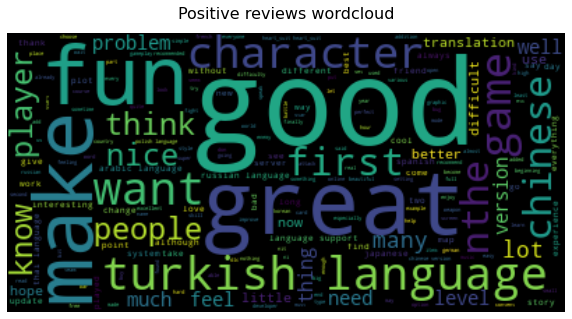

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
#remove some words we noticed that are not very informative
stopwords.update(["game", "understand", 'please', 'really', 'player', 'english',
                  'play', 'will', 'playing', 'still', 'even', 'one', 'time'])
pos = " ".join(review for review in positive.english)
wordcloud = WordCloud(stopwords=stopwords,
                      random_state = 42).generate(pos)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive reviews wordcloud', size=16, pad=14)
plt.show()

Here we see some positve words such as 'great', 'good', 'fun', 'nice', but also words express desire, such as 'need', as well as noticing 'difficulty', 'problem' in the mix. 

Next, let's see the negative reviews word cloud.

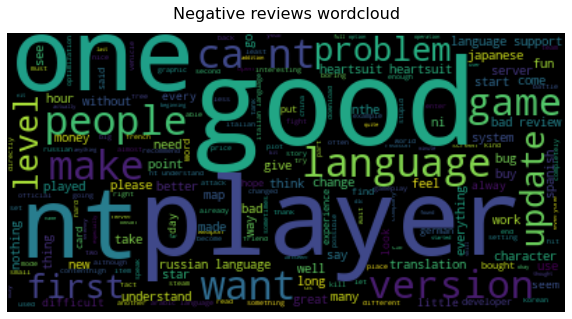

In [ ]:
stopwords = set(STOPWORDS)
#remove some words that are frequent but not informative
stopwords.update(['still', 'now', 'much', 'lot', 'game', 'play', 'time', 
                  'chinese','know','game', 'really', 'player', 'playing',
                  'will', 'even','english', 'turkish'])
neg = " ".join(review for review in negative.english)
wordcloud = WordCloud(stopwords=stopwords,
                      random_state = 42).generate(neg)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative reviews wordcloud', size=16, pad=14)
plt.show()

Here again, we see words like 'good' stand out. We can also see words like 'problem', 'bad', 'bad review', 'need', "can't", which are likely to indicate issues faced by the users. 

Having said that, we do not see distinct patterns in negative reviews, which might present some challenges if we want to distinguish whether it's positive or negative from text. 

### 4.2 Building a logistic regression model to detect positive or negative reviews

In this section, we will try building a simple logistic regression model to determine the sentiment of reviews. 

The reason a logistic regression model is chosen is because it is easy to interpret and can learn fast. It also performs well for the sparse matrix of vectorized words. 

The goal here is not to predict the sentiment of reviews, however. We believe the score given by the user reflects their satisfaction level more accurately, whereas the role of their text reviews is to provide additional information or explanation about that. 

The main goal developing a logisitc model, is to reveal the underlying patterns, if there are any, of the positive and negative reviews. 

#### 4.2.1 Processing the text review column

Before we could use the 'english' and 'positive' column to build a simple logistic regression model, we need to process the text review column. 

In [ ]:
#define a function to further process the reviews text in english
from nltk.corpus import stopwords #it's repetitive but for some reason, leave this out here often gives an error
def process(text):
  tokens = word_tokenize(text)
  # convert to lower case
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  #apply lemmatization 
  words = [lemmatizer.lemmatize(word) for word in words]
  text = " ".join(words)
  return text

We will need both the 'raw' english column, and the processed. So let's change the original translation to 'english_raw', and create a new column containing the processed reviews as 'english'.

In [ ]:
reviews_train_fin.rename(columns = {'english': 'english_raw'}, inplace=True)

In [ ]:
#from nltk.corpus import stopwords
reviews_train_fin['english'] = reviews_train_fin['english_raw'].apply(process)


In [ ]:
reviews_train_fin.head()

,id,text,score,localisation,language,positive,english_raw,english
0,825,"Jogo top demais 👍👍👏👏🤘🤘👌👌😀😀,uma sugestão para a...",5,True,pt,1,game too top :thumbs_up::thumbs_up::clapping_h...,game top thumbsup thumbsup clappinghands clapp...
1,860,gk ada bahasa indonesia 🙄,1,True,id,0,there is no indonesian :face_with_rolling_eyes:,indonesian facewithrollingeyes
2,860,숨은 그림 찾기 좋아합니다! 이런 게임은 단어가 정확해야 하는데 붕대가 반창고로 나...,3,True,ko,1,i love to find hidden objects! in games like t...,love find hidden object game like word must co...
3,687,Perché non lo fate in italiano? ?,5,True,it,1,why don't you do it in italian? ?,nt italian
4,687,L 'unico problema è che non si può cambiare la...,5,True,it,1,the only problem is that you cannot change the...,problem change language mother since english u...


In [ ]:
#let's add a column containing the number of words of each text review
reviews_train_fin["nb_words"] = reviews_train_fin["english_raw"].apply(lambda x: len(x.split(" ")))

In [ ]:
#let's save this as csv for future convenience (hashtag below to avoid accidental click)
#reviews_train_fin.to_csv(r'drive/MyDrive/allcorrect/reviews_train_fin.csv', index = False, header=True)

#### 4.2.2 Building the model

In [ ]:
#read the dataset if needed
reviews_train_fin=pd.read_csv('drive/MyDrive/allcorrect/reviews_train_fin.csv')

In [ ]:
#split the dataframe 
df_new = reviews_train_fin[['english', 'positive']]
df_new.head()

,english,positive
0,game top thumbsup thumbsup clappinghands clapp...,1
1,indonesian facewithrollingeyes,0
2,love find hidden object game like word must co...,1
3,nt italian,1
4,problem change language mother since english u...,1


We will now split the data frame into train and test sets. 80% of the data will be used for training, and 20% will be used for testing.

In [ ]:
# random split train and test data to 80% and 20%
index = df_new.index
df_new['random_number'] = np.random.randn(len(index))
train = df_new[df_new['random_number'] <= 0.8]
test = df_new[df_new['random_number'] > 0.8]

In [ ]:
# count vectorizer:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['english'])
test_matrix = vectorizer.transform(test['english'])

In [ ]:
# Logistic Regression
lr = LogisticRegression()
#split target and independant variables 
X_train = train_matrix
X_test = test_matrix
y_train = train['positive']
y_test = test['positive']

In [ ]:
#Let's find out with what hyperparameter give the best model results.
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.726978 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


It looks like at the default level C=0.1, penalty at 'l2', and solver at 'libnlinear' we have the best results. We will use those hyper parameters 

In [ ]:
#fit the model on data
lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
final_model = lr.fit(X_train,y_train)

In [ ]:
#make predictions
predictions = final_model.predict(X_test)

We have successfully built a simple logistic regression model, and trained the data on it. We also made predictions using the model.

Next, let's test the accuracy of the model 

In [ ]:
# find accuracy, precision, recall:
confusion_matrix(predictions,y_test)

array([[2112,  829],
       [ 555, 1648]])

We can see from above, that the model correctly identified 2112 positive reviews, and 1648 negative reviews. There are 829 false positives, and 555 false negatives. 

Next, let's compare the classfication report of both the training and test data. 

In [ ]:
#let's check the accuracy score when training the data
predictions_train = final_model.predict(X_train)
print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     11450
           1       0.71      0.81      0.76      8010

    accuracy                           0.78     19460
   macro avg       0.78      0.79      0.78     19460
weighted avg       0.79      0.78      0.79     19460



In [ ]:
#check the accuracy score of the test data
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      2941
           1       0.67      0.75      0.70      2203

    accuracy                           0.73      5144
   macro avg       0.73      0.73      0.73      5144
weighted avg       0.74      0.73      0.73      5144



We can see that the training data has an overall 78% prediction accuracy, whereas the test data has 73% prediction accuracy. There is some overfitting of the our logistic model. 

#### 4.2.3 Discriminating words for positive and negative reviews

What would be really useful for our later analysis of the negative reviews is to find out what words or patterns feature the positive or negative reviews. 

Therefore, let’s also look at the 10 most discriminating words for both types of reviews. We’ll do this by looking at the largest and smallest coefficients, respectively.

In [ ]:
print("Top 10 discriminating words for positive reviews:")

feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print(best_positive)

print ("\nTop 10 discriminating words for negative reviews:")    

best_negative_list = []
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    best_negative_list.append(best_negative)
    print (best_negative)
    

Top 10 discriminating words for positive reviews:
('excellent', 1.32548712792049)
('perfect', 1.2050780326598607)
('nice', 1.0232079138947543)
('cool', 0.9698275451262115)
('great', 0.9588029871296673)
('hope', 0.8917295633843866)
('super', 0.8722464884183196)
('fun', 0.8623071185947353)
('thanks', 0.851114792355526)
('best', 0.8108840383443885)

Top 10 discriminating words for negative reviews:
('rubbish', -0.859906982505236)
('refund', -0.7831305048515372)
('terrible', -0.7758104487247457)
('uninstalled', -0.7754485215782855)
('deleted', -0.764396984148872)
('shit', -0.7360137499819063)
('junk', -0.7048669233778114)
('useless', -0.6755117899691384)
('minute', -0.6656362119906866)
('suck', -0.6632916153064022)


We can see the strong sentiment in the words in both categories. We will also save the 10 best negative words in a list in case these come in handy later. 

In [ ]:
best_negative_words = []
for tuple in best_negative_list:
  best_negative_words.append(tuple[0])
print(best_negative_words)


['rubbish', 'refund', 'terrible', 'uninstalled', 'deleted', 'shit', 'junk', 'useless', 'minute', 'suck']


The overall accuracy of the model on the test data is around 73%, which is not too bad, but not great either. Just out of curiosity, let's see if using ngrams will improve the model.

#### 4.2.4 An alternative logistic model

In [ ]:
#For a quick check, we will use the same hyper parameters as in previous logistic model.
ngram_vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(1, 3))
train_matrix = ngram_vectorizer.fit_transform(train['english'])
test_matrix = ngram_vectorizer.transform(test['english'])
# Logistic Regression
lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
#split target and independant variables 
X_train = train_matrix
X_test = test_matrix
y_train = train['positive']
y_test = test['positive']

The accuracy has not improved much. 

In [ ]:
#fit the model on data
final_model = lr.fit(X_train,y_train)
#make predictions
predictions = final_model.predict(X_test)

In [ ]:
confusion_matrix(predictions,y_test)

array([[2143,  844],
       [ 578, 1645]])

In [ ]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      2987
           1       0.66      0.74      0.70      2223

    accuracy                           0.73      5210
   macro avg       0.72      0.73      0.72      5210
weighted avg       0.73      0.73      0.73      5210



The overall accuracy score is about the same as previoius model. 

Let's check on the discriminating words for both types of reviews. 

In [ ]:
print("Top 10 discriminating words for positive reviews:")

feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print(best_positive)

print ("\nTop 10 discriminating words for negative reviews:")    

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)
    

Top 10 discriminating words for positive reviews:
('excellent', 1.6069211495817513)
('perfect', 1.4941673410347258)
('nice', 1.4219719985953414)
('cool', 1.305647144880114)
('fun', 1.2417084150354007)
('great', 1.2340649808389477)
('love', 1.1642497303336958)
('beautiful', 1.0906209704315026)
('finally', 1.08933903185827)
('best', 1.0670130171755505)

Top 10 discriminating words for negative reviews:
('terrible', -1.0163556148919883)
('uninstalled', -0.9947029423154385)
('one star', -0.9197188057249703)
('rubbish', -0.9080992560478668)
('delete', -0.9046694312745339)
('money', -0.897145300097075)
('disappointed', -0.8350550984423387)
('garbage', -0.8198498673532507)
('shit', -0.8110212463934514)
('deleted', -0.8023341380187919)


Okay. We didn't see much difference between the two models. Overall, the models we developed in this section performed not bad, but not great either. This might have to do with our including the neutral reviews as positive, as well as the fact that, as our wordcloud previously shows, both types of reviews do not have very distinguishing patters in their word choices.  

### 4.3 Examine the positive and negative reviews

In this section, we will study the corpus of the positive and negative reviews to see if there is any pattern in their most frequently used words. We will also check the **concordance** of selected words, and well as the most frequent **collocations**. 

In [ ]:
#load reviews_train_fin if needed
reviews_train_fin=pd.read_csv('drive/MyDrive/allcorrect/reviews_train_fin.csv')

In [ ]:
#define a function to build a corpus for the postive and negative reviews 
def corpus(column):
  words_list = []
  for text in column:
    try:
      words = word_tokenize(text)
      words_list += words
    except:
      words = word_tokenize(str(text))
      words_list += words
  return words_list


In [ ]:
#apply the function to get a list of all the words. All texts have been processed earlier already
positive_corpus = corpus(reviews_train_fin[reviews_train_fin['positive'] ==1]['english'])
negative_corpus = corpus(reviews_train_fin[reviews_train_fin['positive'] ==0]['english'])

In [ ]:
#remove all the stop words 
from nltk.corpus import stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update(['still', 'now', 'much', 'lot', 'know','game', 'really', 'even',
                  'also', 'play', 'one', 'n', 'would', 'time', 'players','nt'])
positive_corpus_fin = [w for w in positive_corpus if w not in stopwords]
negative_corpus_fin = [w for w in negative_corpus if w not in stopwords]

Now let's build a frequency distribution of words in the postive and negative corpus respectively. 

In [ ]:
fd_pos = nltk.FreqDist(positive_corpus_fin)
fd_neg = nltk.FreqDist(negative_corpus_fin)

Let's take a look at the top 10 frequently used words in the postive and negative reviews corpus.

In [ ]:
fd_pos.tabulate(10)

language     good     like  english  chinese   please     want  version   player      fun 
    4567     3287     2345     2343     2010     1578     1383     1375     1313     1301 


In [ ]:
fd_neg.tabulate(10)

language  chinese  english   player     like     good     want  version  turkish  russian 
    5143     4054     2850     2206     2091     1991     1821     1710     1610     1574 


The top 10 words in the two list are almost identical. Let's remove the common words ['language', 'english', 'chinese', 'version', 'like', 'good', 'want', 'player'] and see what the new top 10 words are. 


In [ ]:
from nltk.corpus import stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update(['still', 'now', 'much', 'lot', 'know','game', 'really', 'even',
                  'also', 'play', 'one', 'n', 'would', 'time', 'players','nt', 'player',
                  'language', 'english', 'chinese', 'version', 'like', 'good', 'want'])
positive_corpus_fin_2 = [w for w in positive_corpus_fin if w not in stopwords]
negative_corpus_fin_2 = [w for w in negative_corpus_fin if w not in stopwords]
fd_pos_2 = nltk.FreqDist(positive_corpus_fin_2)
fd_neg_2 = nltk.FreqDist(negative_corpus_fin_2)

In [ ]:
display(fd_pos_2.tabulate(10),fd_neg_2.tabulate(10))

 please version  player     fun   great    make  people     add    many russian 
   1578    1375    1313    1301    1194    1158    1151    1121    1103    1076 
 player version russian     bad    make  please      ca     get  people    many 
   2206    1710    1574    1472    1470    1414    1371    1321    1265    1193 


None

None

Now we see a bit more positive words like 'fun' and 'great' in the positve list, and 'bad' shows up in the negative list. Still, not much difference. 

Now let's try extracting some concordance and collocations, using 'language' for example. We will use the english_raw column because we want to include the words and punctuations in this case. 

In [ ]:
reviews_train_fin[reviews_train_fin['positive']==1]['english_raw']

0        game too top :thumbs_up::thumbs_up::clapping_h...
2        i love to find hidden objects! in games like t...
3                        why don't you do it in italian? ?
4        the only problem is that you cannot change the...
5        it is a real fps. \ nthe motif is the battle a...
                               ...                        
15109    very good game but i would be fine if the game...
15110    please ask for thai language so that you can f...
15111                           please add arapic language
15113             good, finally there is a chinese version
15114    more than wonderful, but if the arabic languag...
Name: english_raw, Length: 11619, dtype: object

In [ ]:
#build the raw input corpus
positive_corpus_raw = corpus(reviews_train_fin[reviews_train_fin['positive'] ==1]['english_raw'])
negative_corpus_raw = corpus(reviews_train_fin[reviews_train_fin['positive'] ==0]['english_raw'])
text = nltk.Text(positive_corpus_raw)
#find the first 20 lines of matches
text.concordance("language", lines=20)

Displaying 20 of 4264 matches:
lem is that you can not change the language but my mother since she is english
nd it but i would like the italian language it is a real fps . \ nthe motif is
. \ nartilari \ n + having turkish language support \ n + having a humorous an
ksi̇leri̇ \ n- there is no turkish language support in the sequels of the game
 a fan of aot ( see it in original language with subtitles , say no to the dub
s game a lot . i want to have thai language too . give me the polish language 
 language too . give me the polish language the first chinese dubbing and the 
lf-vampires are out . do some thai language , i ca n't read . it 's cool but i
 legendary but there is no turkish language chinese version ! not bad ! alchem
the italian why ca n't you set the language to german ? : persevering_face : i
ering_face : if there is also thai language will call many more players \ n fo
 for those who are not good at the language , they are considered to practice 
hey are considered to

We can see from above that in positive reviews, people think the game is cool, nice, not bad, as well as request their language version.

Now let's see in the negative reviews, what are the words surrouding language. 

In [ ]:
text = nltk.Text(negative_corpus_raw)
text.concordance("language", lines=20)

Displaying 20 of 4758 matches:
that simply are not in the russian language . i checked it through explanatory
appreciated fun game but no polish language i bought it in may , now it ’ s au
inese ! ! do n't buy 1. the arabic language we have requested hundreds of time
times since 3 years ... the arabic language is quite different from persian 2.
5.if there will be russian turkish language support , please . chinese is mach
sufficient frames we want armenian language support if you turn on the acceler
know unless it 's japanese turkish language support should come . sorry , just
ed and not adapted for the russian language ; \ nimproper , difficult to play 
 work for shit there is no italian language and for waiting why does my friend
ese when playing ? please add more language and arabic language please ! the g
lease add more language and arabic language please ! the game is good but i 'm
ion for pt / br updare changes the language to russian ( or similar ) . to cha
st century , we still

From the negative reviews above surrounding the word 'language', people also request the game in their language, but there is just a little more frunstration. We can notice expressions ike 'english boring", "will delete it", "unless it's japanese", "I've requested for hundreds of times", and etc. 

This is useful because it indicates that studying word concordance might be the way to go to find out underlying patterns in negative reviews. Later in the report when we examine the negative reviews exclusively, we will study the concordance of more words. 

In [ ]:
finder_pos = nltk.collocations.TrigramCollocationFinder.from_words(positive_corpus)
finder_neg = nltk.collocations.TrigramCollocationFinder.from_words(negative_corpus)

In [ ]:
finder_pos.ngram_fd.most_common(10)

[(('turkish', 'language', 'support'), 478),
 (('heartsuit', 'heartsuit', 'heartsuit'), 306),
 (('star', 'star', 'star'), 124),
 (('add', 'arabic', 'language'), 123),
 (('want', 'thai', 'language'), 107),
 (('turkish', 'language', 'option'), 101),
 (('language', 'support', 'come'), 100),
 (('oh', 'oh', 'oh'), 79),
 (('please', 'add', 'russian'), 59),
 (('add', 'russian', 'language'), 59)]

In [ ]:
finder_neg.ngram_fd.most_common(10)

[(('heartsuit', 'heartsuit', 'heartsuit'), 747),
 (('turkish', 'language', 'support'), 564),
 (('chinese', 'chinese', 'chinese'), 223),
 (('chinese', 'want', 'chinese'), 119),
 (('want', 'chinese', 'want'), 118),
 (('give', 'bad', 'review'), 116),
 (('ca', 'nt', 'play'), 114),
 (('turkish', 'language', 'option'), 108),
 (('ha', 'ha', 'ha'), 89),
 (('language', 'support', 'come'), 88)]

In terms of collocations, we don't see any distinguishing patterns. 

Admittedly, the corpus for both types of reviews tend to have a lot in common. However, it could be the discourse of the reviews that are different. It's one thing that people complain about the language but still give it a 4 or 5 star, which indicates that didn't impact their enjoyment of the game, but another if they give it 1 or 2, which indicates that their enjoyment of the game is affected. 


### 4.4 Using the inbuilt sentiment analyzer to detect patterns in reviews

---



In an earlier section, we used the columns of score and English to build a logistic model for distinguishing positive or negative reviews. 

In this seciton, let's try to use a Python package called VADER to analyze the sentiments of the reviews. VADER works best with short reviews such as social media reviews. For better effects, we will break down each review into sentences and use the average sentiment score of those.

#### 4.2.1 Analyzing the sentiment

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
#Let's set set positive as 2, negative as 0, and neutral as 1
def calc_vader_sentiment(text):
  scores = [analyzer.polarity_scores(str(sentence))["compound"] 
            for sentence in nltk.sent_tokenize(text)]
  compound = mean(scores)
  if((compound < 0.05) & (compound > -0.05)):
      sentiment = 1
  elif(compound >= 0.05):
      sentiment = 2
  elif(compound <= -0.05):
      sentiment = 0
  return sentiment

In [ ]:
#we will also add a column showing the compound scores of each review
def sentiment_score(text):
  scores = [analyzer.polarity_scores(str(sentence))["compound"] 
            for sentence in nltk.sent_tokenize(text)]
  compound = mean(scores)
  return compound

In [ ]:
reviews_train_fin['sentiment'] = reviews_train_fin['english'].apply(lambda x: calc_vader_sentiment(x))

In [ ]:
reviews_train_fin['sentiment_score'] = reviews_train_fin['english'].apply(lambda x: sentiment_score(x))

Next, let's check the accuracy of the analyzer. 

In [ ]:
#given we set score 3-5 as positive, when calculating true positive, we will include neutral
pos = reviews_train_fin[reviews_train_fin['positive'] == 1].shape[0]
true_pos = reviews_train_fin[(reviews_train_fin['positive'] == 1) & 
              (reviews_train_fin['sentiment'] == 2)].shape[0] + reviews_train_fin[(reviews_train_fin['positive'] == 1) & 
              (reviews_train_fin['sentiment'] == 1)].shape[0]

In [ ]:
neg = reviews_train_fin[reviews_train_fin['positive'] == 0].shape[0]
true_neg = reviews_train_fin[(reviews_train_fin['positive'] == 0) & (reviews_train_fin['sentiment'] == 0)].shape[0]

In [ ]:
false_pos = reviews_train_fin[(reviews_train_fin['positive'] == 0) & 
              (reviews_train_fin['sentiment'] == 1)].shape[0] + reviews_train_fin[(reviews_train_fin['positive'] == 0) & 
              (reviews_train_fin['sentiment'] == 2)].shape[0]
false_neg = reviews_train_fin[(reviews_train_fin['positive'] == 1) & 
              (reviews_train_fin['sentiment'] == 0)].shape[0]

In [ ]:
print('Number of positive reviews:', pos, 
      '\nNumber of correctly identified positive reviews:', true_pos,
      '\nNumber of wrongly identified positive reviews:', false_pos,
      '\nNumber of negative reviews:', neg,
      '\nnumber of correctly identified negative reviews:', true_neg,
      '\nNumber of wrongly idenfitied negative reviews:', false_neg)

Number of positive reviews: 11619 
Number of correctly identified positive reviews: 10443 
Number of wrongly identified positive reviews: 9631 
Number of negative reviews: 12985 
number of correctly identified negative reviews: 3354 
Number of wrongly idenfitied negative reviews: 1176


The above shows that the inbuilt sentiment analyzer did pretty well catching positive reviews, however, it also categorize an astonishingly large number of negative reviews as positive reviews. 

This is consistent with our previous observation: the negative reviews do not have many distinguishing key words but on the other hand include words with positive sentiment. Therefore these are likely to be categorized as neutral or even positive. 

In [ ]:
#let's check what the sentiment analyzer categorize as neutral reviews
reviews_train_fin.query('sentiment == 1')

,id,text,score,localisation,language,positive,english_raw,english,nb_words,sentiment,sentiment_score
1,860,gk ada bahasa indonesia 🙄,1,True,id,0,there is no indonesian :face_with_rolling_eyes:,indonesian facewithrollingeyes,5,1,0.0
3,687,Perché non lo fate in italiano? ?,5,True,it,1,why don't you do it in italian? ?,nt italian,8,1,0.0
15,841,Dajćie język polski,3,True,pl,1,give me the polish language,give polish language,5,1,0.0
17,27,ทำภาษาไทยให้หน่อยครับผมอ่านไม่ออก,3,True,th,1,"do some thai language, i can't read.",thai language ca nt read,7,1,0.0
25,666,Oyun efsane ama türkçe dili yok,4,True,tr,1,the game is legendary but there is no turkish ...,game legendary turkish language,10,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
24591,847,没繁體中文,1,True,zh-cn,0,no traditional chinese,traditional chinese,3,1,0.0
24592,847,垃圾游戏 不要更新跟好 一更新后中文直接没有,1,True,zh-cn,0,"junk games, don’t update and follow up. after ...",junk game update follow update chinese,15,1,0.0
24594,735,Сделайте русский,2,True,ru,0,make russian,make russian,2,1,0.0
24595,577,Jak w tytule. Wywala z gry co ciekawe tylko po...,1,True,pl,0,"as in title. it crashes the game, interestingl...",title crash game interestingly night expeditio...,21,1,0.0


Just judging from these examples, we can see that the those reviews with sentiment 1 do read neutral despite their positive score being 1 or 0. Interesting though, the analyzer has missed words like 'junk'. 

#### 4.2.2 Analysing reviews with the worst and best scores

Now let's also take a look at the most negative reviews as judged by the analyzer. We will have a look at those reviews shorter than 50 words just for convenience. 

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(reviews_train_fin.query('nb_words<50').sort_values(by='sentiment_score', 
                                        ascending=True).head(10))

,id,text,score,localisation,language,positive,english_raw,english,nb_words,sentiment,sentiment_score
18587,836,"Un gacha qui n'offre rien comme freebie ni comme amusement. Il se sert d'une license pour soutirer le plus d'argent le plus vite possible. Les combats sont ennuyeux, les récompenses sont minables, l'interface utilisateur est fouilie, la traduction est baclée. Bref à éviter.",1,True,fr,0,"a gacha that offers nothing like freebie or fun. he's using a license to get the most money as quickly as possible. the fights are boring, the rewards are lousy, the user interface is lousy, the translation is lousy. in short to avoid.",gacha offer nothing like freebie fun using license get money quickly possible fight boring reward lousy user interface lousy translation lousy short avoid,43,0,-0.9586
21811,271,糟糕的移植，还是阉割的（没有破衣系统），坑爹的DLC价格，婊子还树牌坊的厂商。\n本来有中文，怎么说都不会给差评的。但实在给不出。,0,True,zh-cn,0,"bad transplantation is still castrated (no broken clothes system), the price of dlc is cheating, and the bitch is still the manufacturer of the archway. \noriginally there is chinese, so i won’t give a bad review. but i can't give it.",bad transplantation still castrated broken clothes system price dlc cheating bitch still manufacturer archway noriginally chinese give bad review ca nt give,41,0,-0.9552
22473,885,惡劣的遊戲體驗 惡整玩家的各種活動 浪費時間的PVP對戰 翻譯品質低下 爛遊戲快倒,1,True,ko,0,bad game experience various activities of evil players. time-wasting pvp battles. low translation quality. bad games are falling.,bad game experience various activity evil player timewasting pvp battle low translation quality bad game falling,18,0,-0.9493
15126,281,Oyuna girdim girdiğim gibi öldüm açlıktan öldüm dinazordan öldüm öldümde öldüm bunun yanı sıra türk sunucularını fazla bulamadım çok sıkıcıydı bu oyun yerine başka hayatta kalma oyunları alın tavsiyemdir.,0,True,tr,0,"i entered the game as i entered, i died of starvation, i died of the dinosaur, i died when i died, besides, i could not find many turkish servers, it was very boring. instead of this game, take other survival games.",entered game entered died starvation died dinosaur died died besides could find many turkish server boring instead game take survival game,41,0,-0.9493
15395,832,"Sial an susah bnr ni game bahasa nya juga ga ada bahasa indo pula jdi susah... apa lgi klo dah mati. Drop an langsung ilang udah gw kumpul"" ehh malah mati sueeee",1,True,id,0,"damn it is difficult for the game to speak the language also does not have indonesian so it is difficult ... what if it's dead. the drop was immediately gone, i gathered ""ehh, instead it died sueeee",damn difficult game speak language also indonesian difficult dead drop immediately gone gathered ehh instead died sueeee,37,0,-0.9493
19428,396,不想说，直接差评，各种后台报错退出，关底报错，开箱子报错，分解东西报错。。崩溃的要命\n汉化就不吐槽了,0,True,zh-cn,0,"i don't want to say, direct bad reviews, various back-office error exits, closed-end error reports, open boxes report errors, and decomposition things report errors. . the collapse is terrible\nsinicization will not vomit",nt want say direct bad review various backoffice error exit closedend error report open box report error decomposition thing report error collapse terriblensinicization vomit,32,0,-0.9451
17766,318,严重差评，不仅不屏蔽输入法，而且还没有中文，非常烂，steam最烂的一款了,0,True,zh-cn,0,"seriously bad review, not only does not block the input method, but also has no chinese, very bad, steam's worst one",seriously bad review block input method also chinese bad steam worst one,21,0,-0.9403
7570,908,太容易死了 資源還會一直被偷 新版本爛死了 東西都會被偷光這麼辛苦玩幹嘛,3,True,ko,1,it’s too easy to die. resources will keep being stolen. the new version is rotten to death. everything will be stolen. why are you playing so hard?,easy die resource keep stolen new version rotten death everything stolen playing hard,27,0,-0.9349
16767,815,"Demasiado aburrido, tiempo de reaparición de mascotas doradas muy largas, no regeneración de mana y HP en zonas seguras o fuera de batalla. Nada intuitivo, eventos muy pobres. Comunid

Just from the above 10 reviews, we can see that the users complain about:
- the bad/poor translation;
- the server in their language;
- their difficult playing the game given the lack of their language version; and 
- poor Chinese localisation.


Now, let's have a look at the top positive reviews as judged by the sentiment analyzer. 

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(reviews_train_fin.query('nb_words<50').sort_values(by='sentiment_score', ascending=False).head(10))

,id,text,score,localisation,language,positive,english_raw,english,nb_words,sentiment,sentiment_score
5106,257,Отличная игра. Отличный сюжет. Отличная динамика. Отличная рисовка. Отличное звуковое оформление. Отличная идея с историческими справками. Отличное управление. Отличная локализация. Отличные персонажи. Отличные головоломки.\n10/10,1,True,ru,1,good game. great plot. excellent dynamics. excellent drawing. excellent sound design. great idea with historical background. excellent management. excellent localization. great characters. excellent puzzles. \ n10 / 10,good game great plot excellent dynamic excellent drawing excellent sound design great idea historical background excellent management excellent localization great character excellent puzzle,28,2,0.9912
7853,483,One of the best metroidvania I've played:\n+ wonderful art style\n+ good combat system\n+ interesting plot\n+ rewarding exploration\n+ great music\n+ excellent atmosphere\n- not the best translation\n- small bugs\nHighly recommend!,1,True,en,1,one of the best metroidvania i've played:\n+ wonderful art style\n+ good combat system\n+ interesting plot\n+ rewarding exploration\n+ great music\n+ excellent atmosphere\n- not the best translation\n- small bugs\nhighly recommend!,one best metroidvania played n wonderful art stylen good combat systemn interesting plotn rewarding explorationn great musicn excellent atmospheren best translationn small bugsnhighly recommend,28,2,0.9854
5605,874,"Me encanta el juego, sinceramente el mejor que he probado, estaría genial si pudieran incluir el idioma español, pero independientemente de eso el juego está genial, muy buena jugabilidad, la personalización del personaje, la historia, el estilo del mapa, la verdad muy conforme con el juego muchas gracias 👏",5,True,es,1,"i love the game, honestly the best i've tried, it would be great if they could include the spanish language, but regardless of that the game is great, very good gameplay, character customization, history, map style, really satisfied with the game thank you very much :clapping_hands:",love game honestly best tried would great could include spanish language regardless game great good gameplay character customization history map style really satisfied game thank much clappinghands,46,2,0.9824
12759,72,游戏里搜索峡谷之巅，全中国玩家，全活跃玩家，稳定拿600w宝箱，宝箱物品按蓝星排名自行选取，超热闹超有爱，欢迎你的加入！,5,True,zh-cn,1,"search for the top of the canyon in the game, all chinese players, all active players, stable access to 600w treasure chest, treasure chest items are selected according to the blue star ranking, super lively and super loving, you are welcome to join!",search top canyon game chinese player active player stable access treasure chest treasure chest item selected according blue star ranking super lively super loving welcome join,43,2,0.9816
9203,494,"Great battle system, Fantastic music, great story and cast of characters what's not to love about this game? XSeed always comes through with their fantastic localization, be sure to show them and the developers Falcom some support. The Trails games deserves more love in the west.",1,True,en,1,"great battle system, fantastic music, great story and cast of characters what's not to love about this game? xseed always comes through with their fantastic localization, be sure to show them and the developers falcom some support. the trails games deserves more love in the west.",great battle system fantastic music great story cast character love game xseed always come fantastic localization sure show developer falcom support trail game deserves love west,46,2,0.9803
1803,658,Belkide şimdiye kadar oynadığım en güzel oyunlardan biri diyebilirim . Animasyonlar çok çok iyi bide keşke türkçe olsa bayıldım. Kıyafetler çok çok iyi oyun planlaması zaten çok iyi mükemmel:),5,True,tr,1,"maybe i can say it is one of the most beautiful games i have ever played. animations are very, very good, i wish the bidet was turkish, i loved it. the clothes are very, very good game pl

Indeed, there are lots of postive words used in these 10 examples, from which users express either they love the game despite the lack of their own language version or not so good translation, or in some cases, praised the localisation of the game (title494, title257)

In conclusion, the sentiment analyzer did well recognizing positive reviews, but poorly in recognizing negative reviews, which is consistent with our previous suspection: the lack of distinguishing negative sentiments words overall in negative reviews. 

## 5.Games and languages 

In this section, let's take a look at the 10 languages, as well as games, which have the most localisation reviews. We will also check to see how this differ between positive and negative reviews. 

In [ ]:
#load the dataset if needed
reviews_localisation = pd.read_csv('drive/MyDrive/allcorrect/reviews_localisation.csv')

In [ ]:
#let's get the top 5 languages that have localisation requests
reviews_localisation['language'].value_counts().head()

zh-cn    24106
ko       14245
ru       13786
tr       13579
en       13145
Name: language, dtype: int64

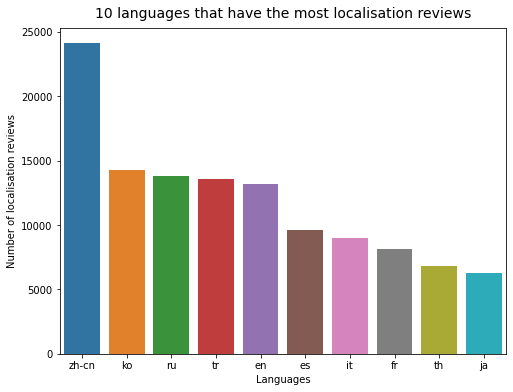

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=reviews_localisation['language'].value_counts().head(10).index,
        y=reviews_localisation['language'].value_counts().head(10))
plt.title("10 languages that have the most localisation reviews", size=14, pad=10)
plt.xlabel("Languages")
plt.ylabel("Number of localisation reviews")
plt.show()

Above, we can the top 10 languages are Chinese simplied, Korean, Russian, Turkish, English, Spanish, Italian, French, Thai, and Japanese. 

In [ ]:
#Let's get the top 5 games that have the most number of reviews about localisation
reviews_localisation['id'].value_counts().head(5)

687    11879
908     9764
841     5721
874     4114
885     3710
Name: id, dtype: int64

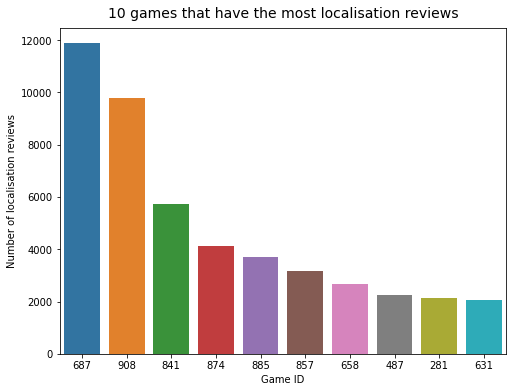

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=reviews_localisation['id'].value_counts().head(10).index.astype(str),
        y=reviews_localisation['id'].value_counts().head(10))
plt.title("10 games that have the most localisation reviews", size=14, pad=10)
plt.xlabel("Game ID")
plt.ylabel("Number of localisation reviews")
plt.show()

From above, we see the 10 games that have the most localisation reviews. Among those, game title687 and title908 have reviews that almost double the number the 3rd place title 841 has. 

It would be interesting to know how positive and negative reviews differ in their game id's and review languages. So let's do that now. 

In [ ]:
reviews_localisation[reviews_localisation['positive'] == 1]['id'].value_counts().head(10)

687    8740
908    8314
841    4332
874    3430
885    2979
857    2509
658    1971
631    1791
739    1438
334    1346
Name: id, dtype: int64

In [ ]:
reviews_localisation[reviews_localisation['positive'] == 0]['id'].value_counts().head(10)

687    3139
487    1847
908    1450
841    1389
281    1003
885     731
658     693
874     684
249     676
857     657
Name: id, dtype: int64

Title687 top the list in both categories. title 487, 281, 249 only show up in the top 10 for negative reviews. 

A potential further investigation for the company is to examine the reviews for each game if that is of any interest, but given the space of this report, we wouldn't go that far here. 

In [ ]:
#Now let's check the top 5 languages in which localisation reviews are positive
reviews_localisation[reviews_localisation['positive'] == True]['language'].value_counts().head(10).

zh-cn    17189
ko       10626
tr       10293
en       10090
ru       10012
es        7619
it        6857
fr        6289
th        6029
ja        4789
Name: language, dtype: int64

In [ ]:
#and those are negative
reviews_localisation[reviews_localisation['positive'] == False]['language'].value_counts().head(10)

zh-cn    6917
ru       3774
ko       3619
tr       3286
en       3055
it       2138
es       2020
fr       1836
ja       1502
de       1305
Name: language, dtype: int64

Other than Thai showing up in the positive reviews top list, and German in the negative reviews list, rest 9 languages remain the same. 

In the last section of this report, we will further look at the countries and games that have the most negative reviews. 

## 6.Examine the negative reviews

In this section, we will use the reviews_negative dataset we saved and exported earlier. 

First, we will process the text previews column in similar ways as in part 4. Then we will have a look at the distribution of the length of the reviews, and the top languages in which those negative reviews were written, as well as which games these are about. 

Following that, we will use word concordance and collocations to find out what characterize negative reviews. 

In [ ]:
#load the dataset if needed
reviews_negative = pd.read_csv('drive/MyDrive/allcorrect/reviews_negative.csv')

In [ ]:
#first let's check the negative reviews dataset
reviews_negative.head()

,id,text,score,localisation,language,positive,english
0,874,"Esta muy bueno, pero hasta que no lo pongan en...",2,True,es,0,"It is very good, but until they put it in Span..."
1,395,왜 안 한글이냐;\n-----------------------------------...,0,True,ko,0,Why is it not Korean;\n-----------------------...
2,908,沒有中文。。。看不懂。。。怎麼玩？？？,1,True,zh-cn,0,no Chinese. . . can not read it. . . How to pl...
3,308,"If you are big on grinding endlessly, censorsh...",0,True,en,0,"If you are big on grinding endlessly, censorsh..."
4,836,"SAINT SAIA AQUANIN Uma dica Da próxima vez, co...",1,True,pt,0,"SAINT SAIA AQUANIN A tip Next time, hire a pos..."


In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(reviews_negative.tail())

,id,text,score,localisation,language,positive,english
31626,908,keşke türkçe olsaydı,1,True,tr,0,I wish it was Turkish
31627,675,Нужен русский,1,True,ru,0,Need Russian
31628,138,มันเป็นภาษาอะไรครับ งงใจ,2,True,th,0,What language is it? Confused?
31629,310,垃圾游戏，更新以后mod不能用就算了，汉化也不能用了，还你妈不出官方中文。bull ♥♥♥♥,0,True,zh-cn,0,"Junk game, even if the mod can't be used after the update, the localization can't be used, and your mother can't publish official Chinese. bull :heart_suit::heart_suit::heart_suit::heart_suit:"
31630,841,Türkçe dil seçeneği yok,1,True,tr,0,No Turkish language option


### 6.1 Processing the negative reviews text

In [ ]:
#we will process the english in similar ways as before and save them to a new variable
reviews_negative_fin = reviews_negative.rename(columns={'english': 'english_raw'})

In [ ]:
#process the emojis in the column
reviews_negative_fin['english_raw'] = reviews_negative_fin['english_raw'].apply(add_space)
reviews_negative_fin['english_raw'] = reviews_negative_fin['english_raw'].apply(convert_emojis)

In [ ]:
#Let's add a colum showing how many words each review has
reviews_negative_fin["nb_words"] = reviews_negative_fin["english_raw"].apply(lambda x: len(x.split(" ")))

In [ ]:
#For some reason, we have to import stopwords everytime, otherwise it gives an error
from nltk.corpus import stopwords
reviews_negative_fin['english'] = reviews_negative_fin['english_raw'].apply(process)

In [ ]:
#save as csv for later convenience 
#reviews_negative_fin.to_csv(r'drive/MyDrive/allcorrect/reviews_negative_fin.csv', index = False, header=True)

In [ ]:
#read into the dataset again when needed
reviews_negative_fin = pd.read_csv('drive/MyDrive/allcorrect/reviews_negative_fin.csv')

In [ ]:
reviews_negative_fin.shape[0]

31631

We have 31631 negative reviews about localisation in the dataset. 

Now let's look at the length of the reviews in English by the measure of word number. 

### 6.2 Distribution of length of reviews

In [ ]:
reviews_negative_fin['nb_words'].describe()

count    31631.000000
mean        53.955107
std        107.933576
min          1.000000
25%          9.000000
50%         20.000000
75%         49.000000
max       1308.000000
Name: nb_words, dtype: float64

The median length is 20 words, with some extreme outliers on the higher end to pull the average length to around 53 words.

Next, let's check the histogram of the word number distribution.

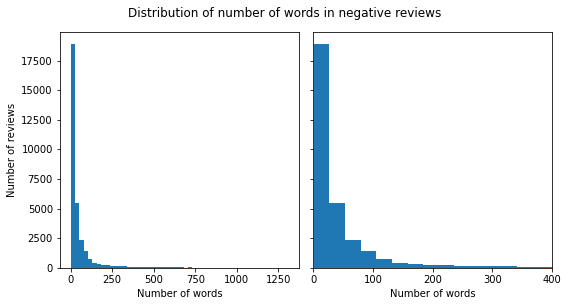

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize= (8, 4))
fig.suptitle("Distribution of number of words in negative reviews", y=1.05, x=0.5)
ax1.hist(reviews_negative_fin['nb_words'], bins=50)
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Number of reviews')

ax2.hist(reviews_negative_fin['nb_words'], bins=50) 
ax2.set_xlim(0,400)
ax2.set_xlabel('Number of words')
plt.tight_layout()

From the above histogram, we can see that most of the negative reviews are of the length of under 50 words. 

This information may come in handy when we want to read through the reviews to examine patterns later in the section of concordance and collocations. 

### 6.3 Top languages and games for the negative reviews

In [ ]:
reviews_negative_fin['language'].value_counts().head(10)

array([6212, 3366, 3215, 2959, 2690, 1926, 1818, 1648, 1333, 1149])

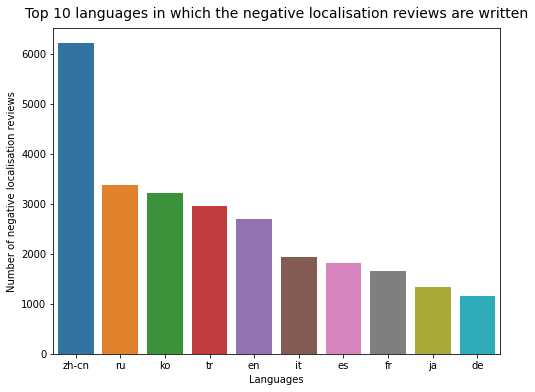

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=reviews_negative_fin['language'].value_counts().head(10).index,
        y=reviews_negative_fin['language'].value_counts().head(10))
plt.title("Top 10 languages in which the negative localisation reviews are written", size=14, pad=10)
plt.xlabel("Languages")
plt.ylabel("Number of negative localisation reviews")
plt.show()

As we can see from the above, the top 10 languages are Chinese simplied, Russian, Korean, Turkish, English, Italian, Spanish, French, Japanese, and German. 

Next, let's take a look at what are the 10 game that have the most negative reviews about localisation. 

In [ ]:
reviews_negative_fin['id'].value_counts().head(10)

687    2836
487    1655
908    1307
841    1230
281     885
885     651
658     632
874     617
857     585
249     576
Name: id, dtype: int64

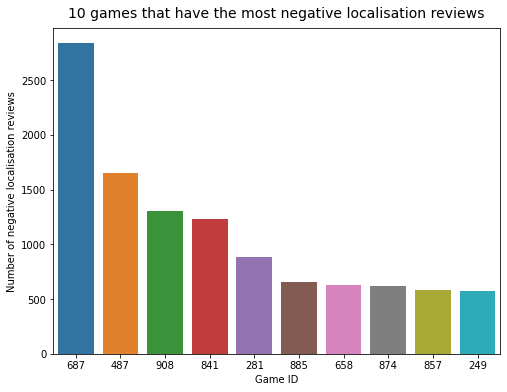

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=reviews_negative_fin['id'].value_counts().head(10).index.astype(str),
        y=reviews_negative_fin['id'].value_counts().head(10))
plt.title("10 games that have the most negative localisation reviews", size=14, pad=10)
plt.xlabel("Game ID")
plt.ylabel("Number of negative localisation reviews")
plt.show()

The above shows the 10 games that have the most negative reviews. As our filtering of the localisation reviews are not the most vigorous, these games may not get their share of the negative reivews entirely because of their localisation issues. However, it is worth the attention of the company and perhaps conduct some further investigation. 

### 6.4 Examining the negative reviews using concordances and collocations

In [ ]:
#quick check of the text input
reviews_negative_fin['english_raw']

0        It is very good, but until they put it in Span...
1        Why is it not Korean;\n-----------------------...
2        no Chinese. . . can not read it. . . How to pl...
3        If you are big on grinding endlessly, censorsh...
4        SAINT SAIA AQUANIN A tip Next time, hire a pos...
                               ...                        
31626                                I wish it was Turkish
31627                                         Need Russian
31628                       What language is it? Confused?
31629    Junk game, even if the mod can't be used after...
31630                           No Turkish language option
Name: english_raw, Length: 31631, dtype: object

In [ ]:
#from the logistic model we had earlier, we gwnerated the following discriminating key words:
print(best_negative_words)

['rubbish', 'refund', 'terrible', 'uninstalled', 'deleted', 'shit', 'junk', 'useless', 'minute', 'suck']


In what follows, we will review the concordance with 'langauge', as well as some of the above words from the list, as well as the words we've noticed previously from the negative reviews wordcloud. 

For each concordance, we will generate 20 matching lines to examine. 

In [ ]:
#First, here is a previous function we've defined to get corpus out of a text column
def corpus(column):
  words_list = []
  for text in column:
    try:
      words = word_tokenize(text)
      words_list += words
    except:
      words = word_tokenize(str(text))
      words_list += words
  return words_list


#### 6.4.1 "language" concordances

In [ ]:
#build the raw input corpus
from nltk.corpus import stopwords
negative_corpus_full = corpus(reviews_negative_fin['english_raw'])
text = nltk.Text(negative_corpus_full)
#find the first 20 lines of matches
text.concordance("language", lines=20)

Displaying 20 of 11812 matches:
sorship and newtering all kinds of language in the game chat , and other such 
then returned to the whole foreign language , do n't you hurry up and fix it b
 and fix the problem . The Italian language is missing uninstalled If there is
uninstalled If there is no Turkish language , how do I say it ? I did not unde
 Russian ? Why is there no Russian language ? Please translate it into Korean 
ithout Chinese There is no Russian language in the game . Don ’ t talk about t
uld also know that by changing the language in the launcher , you can get diff
ame 's website ) , put the English language and get goodies . Forget about cam
e only \ `` experts \ '' . Turkish language support should be added immediatel
ing Why do n't you have Vietnamese language ? Good game without Vietnamese is 
tack screens are garbled , and the language becomes incomplete , which is very
thing if you please add the Arabic language Игра теряет рентабельность , попул
very big minus there

As we observed previously, concordance around 'language' in the reviews all focus on the lack of the users' native language in the games, with the negatives reviews having an additional urgency. 

These can be shown in, for example:
- "When is Polish language???????" with many questions marks to emphasize;
- the '!" after "there is no Russian language";
- please add/put language of ...; 
- "Turkish support should be added immediately";
- "don't your hurry up and fix it". 

#### 6.4.2 "problem" concordances

In [ ]:
#check the concordance with 'problem' 
text.concordance("problem", lines=20)

Displaying 20 of 1756 matches:
x it back to Vietnamese and fix the problem . The Italian language is missing u
n the game . Don ’ t talk about the problem of Chinese translation\nIf you are 
y under the map and killed them . A problem that I constantly find myself havin
 completed \ nIt seems that it is a problem to be able to play in a specific la
n . Please answer in German ... the problem is still there The Chinese translat
ill definitely take at least a ping problem fixlen until ( is experiencing due 
l ( is experiencing due to the ping problem server system closest to turkey ser
 is updated ? The game has a lot of problem . Firstly , what is not for the Ara
olk methods to solve the lock frame problem and I was very happy to play\nI oft
estra 2 ... \ nBut it 's also a big problem ... the game is ... . IT STILL HAS 
eted . \ nIn In this case the whole problem relates to the DLC \ `` Walking Tig
ive a thumbs up . There is only one problem , this is Russian English is not wr
rmation ,

As far as localisation is concerned, we can see from above that, there is the problem with:
- "chinese translation" showing up three times out of the 20 lines; 
- Russian English. 

#### 6.4.3 "difficult" concordances

In [ ]:
text.concordance("difficult", lines=20)

Displaying 20 of 1198 matches:
e next level . So the game is very difficult solo with all that and its perma-d
ood game without Vietnamese is too difficult to play . Like game \ nLast day on
 level 104 . Duel without power-up difficult , if not impossible . The bait ( f
en anyhow , because of which it is difficult to understand what effect the card
use the method of Japanese mod was difficult . Taiwan , China It sucks ! It 's 
e blood . ATTENTION this will be a difficult review \\ a review from a professi
uncorrected bugs . \ N- Control is difficult , especially movements such as cov
here is no Indonesian , it is very difficult to play for those who already unde
 , nothing is understood and it is difficult to move forward , you can not gath
about this game ? \ n Also , it 's difficult to understand because it 's not in
utiful language is Russian . It is difficult to have Thai language and it is di
lt to have Thai language and it is difficult for him to be able to play next to
sions , l

Among the concordance with 'difficult', we see:  
- "without Vietamaese it is too difficult to play";
- "difficult to understand becuase it is not in"; 
- "difficult to understand instructions"; 
- "the method of Japanese mod is difficult"; 
- "Thai language... difficult ... to be able to play"; 

This shows that for some users, without having the game in their native langauge, it's difficult for them to play or enjoy it. 

#### 6.4.4 "bad" concordances

In [ ]:
text.concordance("bad", lines=20)

Displaying 20 of 3634 matches:
nsive . I feel that this update has a bad game experience . Stop playing , just
nough , still ? \ nWell , comment The bad , now the good-mediocre . \ n1- Reali
licked several yellow links , and the bad reviews continued . \nThe sound of th
 opening animation was huge , and the bad review +1 . \nLook at the settings fi
 to find Chinese patch ? Keep up with bad reviews . \nWhether it is a new begin
tupid description of the world view , bad review +2 . \nPlay the game directly 
re better than yours in this regard ? Bad review +6.\n ( As the game time gets 
on , not strung out by heavy spikes ! Bad review ! ( Battlefield 1 salted fish 
\nwait\nThey seem to be DLC content\n Bad review +10.\n1/17th Season Pass 2 ush
base on twitter . Syper games but too bad we ca n't put it in French Fixed an i
 More expensive than European games ! Bad review . . . . . \nThe Chinese people
re too much but graphics can be quite bad , especially on the map Ragnarok\n- R
n too muc

Around 'bad', we see:
- 'Chinese patch";
- "too bad can't put it in French";
- "only in English";
- "bad and stereotyped"; 
- "Turkish language please"; and
- "no Chinese". 

#### 6.4.5 "junk" concordances

In [ ]:
text.concordance("junk", lines=20)

Displaying 20 of 188 matches:
ne : :Russia : :Russia : :Russia : A junk game , which is a fraud and fraud , 
he guys doing your best What kind of junk games ? They are rich people who ope
 is eternal . There is no Portuguese Junk games , discrimination against Chine
ch ? Language There is no in Spanish Junk game I 29lv \nAfter doing all the ta
market is just a pot of soup by your junk agents ! The story is very simple : 
really annoying ? Just uninstall the junk game . Need Chinese very nice but I 
d made this optimization into such a junk product after a two-month delay , wh
ugs , the game is severely dropped , junk games are not recommended ! ! ! ! ! 
 . No comment on Glory . It is not a junk game , but better than a junk game .
 not a junk game , but better than a junk game . \nPlay , still can play , but
est version always prompts updates , junk games 1 star until Turkish language 
ty + old and worn\nAmerican armor is junk quality + insufficient materials\nGe
in its current status 

Around 'junk', we see:
- 'Russia"; 
- "no Portuguese"; 
- "no in Spanish"; 
- "discrimination against Chinese"; 
- "1 star until Turkish language"; 
- "boring everything in English"; 
- "could have provided Chinese"; 
-  "racial discrimination". 

#### 6.4.6 "garbage" concordances

In [ ]:
text.concordance("garbage", lines=20)

Displaying 20 of 382 matches:
outdated by 20 years . It 's really garbage . Why is the price in the low-price
t : You stardock can ’ t close this garbage game can ’ t close steam\nThe theme
e , and there is no one of the most garbage in Japanese games . The lens can no
, all of a sudden he was written to garbage support . Answer : Proof that ( ana
he management response is less than garbage . \ n Many bugs . \ n For those wit
l drop the frame , the console game garbage optimization drops the frame , the 
ian , then a star will be added The garbage machine is turned into Chinese , an
's no longer a fucking game , but a garbage game . No traditional Chinese versi
, and it doesn ’ t support Chinese~ Garbage games , racial discrimination suppr
This is Iranai ! Indonesian made it Garbage sinicization , garbage The game cra
sian made it Garbage sinicization , garbage The game crashed as soon as I made 
re any optimization follow-up Total garbage am German and I have to play as a R
hinese , p

Around 'garbage", we see:
- "no traditional Chinese"; 
- "doesn't support Chinese"; 
- "racial discrimination"; 
- "this is Iran";
- "German"; 
- "Without Chinese". 

#### 6.4.7 "rubbish" concordances

In [ ]:
text.concordance("rubbish", lines=20)

Displaying 20 of 396 matches:
ack me and you . I don ’ t know how rubbish the official anti-plug mechanism is
e translation is completely useless rubbish , and the tutorials are completely 
 Europe , and the server is equally rubbish . It is not recommended at all . Wh
nded at all . Where does the global rubbish server come from the courage of man
al is good , but the translation is rubbish ! You ca n't play like that Italian
age and do you want so much money ! Rubbish developers say they don ’ t want to
e by myself , but it was repaired . Rubbish Why English ? It does n't correspon
translation ) and now it 's pay2win rubbish . If there is Chinese , I will defi
in American Spanish Optimization is rubbish . Why should I delete Chinese and C
 kinds of stuck optimization is too rubbish , so expensive to buy such a thing 
vomited , and what I did was really rubbish this time . Any previous version is
ble . \nThe Chinese localization is RUBBISH , even worse than Google translatio
 strong te

Around "rubbish", we see expressions like:
- "translation is rubbish"; 
- "why English";
- "If there is Chinese"; 
- "The Chinese localisation is rubbish, even worse than google translation"; 
- "don't let the Chinese play"; 
- "Turkish language please"; 
- "Polish language is missing";
- "no translation into Spanish". 

#### 6.4.8 "terrible" concordances

In [ ]:
text.concordance("terrible", lines=20)

Displaying 20 of 412 matches:
ne of the most gamebreaking is the terrible hitboxes/hit registry , sometimes 
 Another gamebreaking issue is the terrible ai following , quite often when at
ation system\n- Buggy dino ai's\n- Terrible gathering , xp and taming rates on
ctives , maps and explanations are terrible and chaotic . \ N- Quite a few unc
 ) Game bottom . Crooked control , terrible translation . The gameplay is bori
ey pretty much copy/pasted tera 's terrible UI ( why copy a UI that is known f
- in German . It was an absolutely terrible decision ! A drivel that you absol
evelopment of this game was also a terrible mistake . You are part of the mili
The development of this game was a terrible mistake . You belong to the milita
ayer ? In addition to enduring the terrible game experience , every time Ubiso
 bad . Everything about it is just terrible . It crashes constantly many times
u 'll definitely be hit . A really terrible game . PS I tried it after a long 
ous version is complet

Around "terrible", we have:
- "terrible translation"; 
- "change the language"; 
- "not to understand anything". 

#### 6.4.9 "deleted" concordances

In [ ]:
text.concordance("deleted", lines=20)

Displaying 20 of 504 matches:
rsion is the very bad . My phone is deleted south park games . Please put this 
attention , the registration can be deleted . We expect Turkish language suppor
isoft , but the Chinese language is deleted if tm ’ s bugs and optimizations ar
more languages pls . No Chinese ... Deleted every minute after downloading ! Ru
alled all the C++ related files and deleted them on Steam , changed the path , 
! There is no traditional Chinese , deleted ! The only thing I do n't like is t
laying FF now . Because of this , I deleted the game , and a lot was invested i
date . Installed . All in English ( Deleted ( Energy runs out very quickly . Th
? ? ? ? ? ? ? No Russian language , deleted The energy runs out immediately . A
od and movie clips being edited and deleted , we still love our country , so pl
o not recommend a terrible game , I deleted 3 lvl . Do n't worry about your unf
I can recommend this game 0 will be deleted I want in Russian I carried it and 
 I want in

From the above, we can notice the following:
- "Chinese";
- "no Chinese";
- "no traditional Chinese"; 
- "all in English";
- "no Russian language";
- "I want in Russian";
- "I deleted because there is no Turkish"; 
and some partial expressions we suspect could be about translations. 

#### 6.4.10 "shit" concordances

In [ ]:
text.concordance("shit", lines=20)

Displaying 20 of 469 matches:
rce you to issue a season pass ? ! A shit company that bothers to erase Japane
\n2 . Optimization is just a fucking shit . The GPU and CPU utilization rates 
s ro2 , and now it is optimized like shit . The configuration in ro2 is stable
 qualified people . Are you worthy ? Shit company ! The management also helps 
t the picture quality ? What kind of shit server is RTS ? Why is no one playin
ne playing a good RTS ? What kind of shit resolution does RTS do ? Good RTS 3 
layers . harmonious . Translation is shit . Chinese translation Play very lagg
 include charity Raw , non-optimized shit . I requested a refund . I do not re
No Russian language ! ! ! ! Optimize shit server , discriminate against Chines
erver , discriminate against Chinese shit This game fully embodies the essence
ings in the official server . . Meow shit too . . \n Then lock the zone in Chi
sions and especially the net code to shit ... but for its time and for its big
 proves how much the c

From the above, as far as localisation is concerned, we notice expressions around the word "shit" like:
- "translation is shit";
- "discriminate agains Chinese". 

From the study of the above concordances, we gather some ideas why the reviews are negative. Next, let's also take a look at the most common collocations in the negative reviews. 

#### 6.4.11 most common collocations

In [ ]:
#Here we want the english_raw column without the punctuations and non letters. 
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in negative_corpus_full]
words = [word for word in stripped if word.isalpha()]
finder = nltk.collocations.QuadgramCollocationFinder.from_words(words)
finder.ngram_fd.most_common(10)

[(('heartsuit', 'heartsuit', 'heartsuit', 'heartsuit'), 1677),
 (('I', 'do', 'nt', 'know'), 625),
 (('I', 'do', 'nt', 'understand'), 504),
 (('is', 'no', 'Russian', 'language'), 397),
 (('I', 'don', 't', 'know'), 390),
 (('for', 'a', 'long', 'time'), 366),
 (('and', 'there', 'is', 'no'), 342),
 (('is', 'no', 'Turkish', 'language'), 321),
 (('of', 'the', 'game', 'is'), 282),
 (('there', 'is', 'no', 'Turkish'), 259)]

It's quite obvious from the above that the most common collocations concerns the lack of languages, either it's Russian or Turkish. There is also "I don't know", "I don't understand", potentially indicating the users not understanding the games without certain languages. 

Next, let's examine the reviews that contain the above collocations. 

In [ ]:
#let's show the reviews containing 'heartsuit" but also shorter than 50 words. 
with pd.option_context('display.max_colwidth', None):
  display(reviews_negative_fin[(reviews_negative_fin['english'].str.contains('heartsuit') == True) & 
                               (reviews_negative_fin['nb_words'] <50)].head())

As seen from above, 'heartsuit' potentially is a bug, not necessarily a positive emotion. Let's disregard that. 

Next, let's have a look at the rows that contain **"I don't understand"**.

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(reviews_negative_fin[(reviews_negative_fin['english_raw'].str.contains("I don't understand") == True) &
                               (reviews_negative_fin['nb_words']<50)].head())

,id,text,score,localisation,language,positive,english_raw,english,nb_words
115,695,Bi kere türkçe değil anlamiyorum ve sürekli süpürge sapı veriyo ama hiç çivi falan vermiyor,1,True,tr,0,"First of all, I don't understand it is not Turkish and it always gives a broom handle, but it never gives a nail or something.",first nt understand turkish always give broom handle never give nail something,25
412,687,io qualcosa di inglese lo parlo e un po' lo capisco ma ci sono alcune cose che non capisco per favore mettete l'italiano! comunque bella come idea,2,True,it,0,I speak some English and I understand a little but there are some things I don't understand please put Italian! still nice as an idea,speak english understand little thing nt understand please put italian still nice idea,25
422,667,日本語じゃないからわからない すぐやめた,1,True,ja,0,I don't understand because it's not Japanese,nt understand japanese,7
766,687,Non capidco niente in inglese,1,True,it,0,I don't understand anything in English,nt understand anything english,6
872,687,Io l'ho appena installato ho giocato massimo 2 minuti perché non capisco molto l'inglese...è bello ma per chi non capisce per niente l'inglese è inutile...,1,True,it,0,"I just installed it, I played a maximum of 2 minutes because I don't understand English very much ... it's nice but for those who don't understand English at all it's useless ...",installed played maximum minute nt understand english much nice nt understand english useless,33


From the 5 examples above, we can see that "I don't understand" are quite likely associated with users not understanding the language of the game. 

Finally, let's check **I don't know**. 

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(reviews_negative_fin[(reviews_negative_fin['english_raw'].str.contains("I don't know") == True) &
                                 (reviews_negative_fin['nb_words']<50)].head(10))

,id,text,score,localisation,language,positive,english_raw,english,nb_words
157,819,沒有中文不知道說什麼-,1,True,ko,0,I don't know what to say without Chinese-,nt know say without chinese,8
384,739,"Me pones los términos y condiciones en inglés, cuando no lo manejo. No se \nlo que acepto, así que desintalo.",1,True,es,0,"You put the terms and conditions in English for me, when I don't use it. I don't know \ Nwhat I accept, so I uninstalled it.",put term condition english nt use nt know nwhat accept uninstalled,26
409,686,ผมโหลดมาแล้วคับ ช่วยเอาภาษาไทยเข้ามาได้มั้ยคับ ผมเล่นไม่รู้เรื่องเลยคับไม่เก่งอังกฤษ คนตายหมดเลยคับ ช่วยหน่อยยะคับ ท้าได้ภาษาไทยจะดีมากคับ,2,True,th,0,"I loaded it. Can you bring Thai language? I don't know anything about it. Not good at English. All the dead. Help me please Can challenge Thai language, it will be very good.",loaded bring thai language nt know anything good english dead help please challenge thai language good,33
516,821,Não sei de inglês tenho 9 anos e esso online e não parece nenhuuuuuuuuum pouco com minecraft,1,True,pt,0,"I don't know English, I am 9 years old and esso online and it doesn't look like anything with minecraft",nt know english year old esso online nt look like anything minecraft,20
576,687,Gra wydaje sie bardzo fajne ale nie ma polskiego języka a angielskiego za dobrze nie znam jakbyście mogli dodać polski byłabym uszczęśliwiona i bym dała 5 gwiazdek,1,True,pl,0,The game seems very cool but there is no Polish language and I don't know English very well if you could add Polish I would be happy and give 5 stars,game seems cool polish language nt know english well could add polish would happy give star,31
672,881,Sebastian Służą mnie ta gra cały czas mnie wywala z gry tracę tylko pkt i nie wiem czemu pisałem już ale każe mi po angielsku pisać ją nie znam angielskiego,1,True,pl,0,"Sebastian Serves me, this game crashes me all the time, I only lose a point and I don't know why I wrote, but he tells me to write it in English, I don't know English",sebastian serf game crash time lose point nt know wrote tell write english nt know english,35
779,687,Я не знаю как поменять язык с английского,1,True,ru,0,I don't know how to change the language from English,nt know change language english,10
837,850,제발 도와주세요 이게임다영어로되어있고 어디다 써야할지몰라서 일단 여기에 남겨요 저희아들이 7살인데 아빠폰으로 이게임을 다운받아하다 56000 원 루비인지 모르겠지만 총 168000원을 결제했어요 모르고있다 발견해서 이리저리 알아보다 어떻게 해야할지 도저히 못찾아서 여기다 올렸어요 어떻게해야하나요?,1,True,ko,0,"Please help me. This game is in English and I don't know where to use it, so I left it here. My son is 7 years old. I downloaded this game on my dad's phone. I couldn't find what to do, so I posted it here.",please help game english nt know use left son year old downloaded game dad phone could nt find posted,46
1028,881,海賊の戦力が酷すぎて攻略出来ない、ランク２つ位落とせよ（｀Δ´）英語で書かれてもわかんねーよ purees ememyye reberudaun pureesu aihabu JAPPAN,1,True,ja,0,"The pirate's strength is too terrible to capture, drop the rank 2 (`Δ´) I don't know if it's written in English purees ememyye reberudaun pureesu aihabu JAPPAN",pirate strength terrible capture drop rank nt know written english puree ememyye reberudaun pureesu aihabu jappan,27
1107,658,근뎅 아주 재미있는데...영어라서 모르겠어요ㅎ이거 한국어로 어떻게해요??,2,True,ko,0,It's very interesting... I don't know because it's English. How can I do this in Korean??,interesting nt know english korean,16


From the five examples we can see that, "I don't know" also concerns language: users don't know English, which creates barriers for them to play the game. 

## 7.Conclusion

In this report, we've first imported, combined and cleaned our datasets provided by the company. Then, using a small set of data, we worked on to have developed an extended list of keywords to filter reviews about localisation. 

**Key words**:
It's interesting to notice that we would have missed a lot of reviews about localisation, in Chinese for example, if we only used the original keywords provided. The main reason for this is that there are multiple ways of expressing the same meaning in all languages. Even when translated in English, these may not necessarily be the same word. For example, some of the expressions in Chinese which have similar meanings to **localisation** are actually translated as **sinicization**. It might be of interest of the company to develop an extended list of key words for each language, if accuracy in detection is the goal. 

**Languages**:
We also noticed that, there are 27 languages provided in the keywords list, however, we detected an additional 21 languages from the dataset. Depending on the goal of the company, this might be worth further investigaton too. 

**Localisation reviews**:
Using the key words, we've identified 152,447 reviews which are about localisation, representing slightly over 1% of the data. However, we admit that not all would be exactly about the localisation. For further accuracy, the data will be check more vigorously. 

**Positive vs. negative reviews**:
We arbitrarily divided pc reviews with score 1 and mobile reviews with score 3-5 as positive reviews, and pc game with score 0 and mobile games with score 1-2 as negative reviews. we ended up, from all the localisation reviews, having slightly over 75% of positive reviews, and less than 25% of negative reviews. 

An investigation of the positive and negative reviews translated in English shows that they exhibit similar structures in language use, both noting the lack of game in a specific language and the difficulty that has caused in playing. A difference that can be noticed is that for the positive reviews, the lack of a local language version may not have impacted the enjoyment of the game, whereas for negative reviews, no local language version, bad translation add to the barriers to game play, even arousing a feeling of discrimination in some cases, hence a hint of urgency and frustration detected in negative reviews. 

Having similar structures and word choices presents some challenge for developing an effective model to predict review sentiment. However, we still have managed to fit a few models which allow us to generate some helpful discriminating words to further examine negative reviews. 

The word concordances and collocations also proved to be helpful in detecting patterns in positive and negative reviews. 

**Reasons for negative reviews**: By examining the concordances of the most discriminating negative words, as well as the most common collocations in negative reviews, we noted the top reasons for negative sentiment as below: 

1. lack of specific language 
2. bad/poor/terrible translation 
3. difficult to understand or play in English
4. repeated request to add language not addressed
5. discrimination/stereotype 
6. bad/awkward localisation 

The above is however just an overview by going through the data. For more accuracy on each of the reasons, we will need to study the reviews data more closely. 

**Games and regions**:

If it is of any interest, we also found out from the data what languages and games have the most localisation reviews (in particular, negative localisaton reviews). These are two possible directions to investigate the data further. 



## Additional - for data studio 

For the datasets to be importable to data studio, we will have to clean up the line breaks and commas within the text input. 

We will use three datasets to generate the datastudio report: all the localisation reviews; approximately 15% of the total localisation reviews with English translations; and all the negative localisation reviews with English translations. 

- reviews_localisation
- reviews_train_fin
- reviews_negative 

In what follows, we will clean up these datasets for data studio report. 

In [ ]:
reviews_localisation.shape[0]

152447

In [ ]:
#remove the line breaks and replace with space in all three datasets
reviews_localisation = reviews_localisation.replace("\n", " ", regex=True)
reviews_train_fin = reviews_train_fin.replace("\n", " ", regex=True)
reviews_negative_fin = reviews_negative_fin.replace("\n", " ", regex=True)


reviews_localisation = reviews_localisation.replace("\r", " ", regex=True)
reviews_train_fin = reviews_train_fin.replace("\r", " ", regex=True)
reviews_negative_fin = reviews_negative_fin.replace("\r", " ", regex=True)


reviews_localisation = reviews_localisation.replace("\\n", " ", regex=True)
reviews_train_fin = reviews_train_fin.replace("\\n", " ", regex=True)
reviews_negative_fin = reviews_negative_fin.replace("\\n", " ", regex=True)

In [ ]:
#replace all the commas with full stop 
reviews_localisation = reviews_localisation.replace(",", ".", regex=True)
reviews_train_fin = reviews_train_fin.replace(",", ".", regex=True)
reviews_negative_fin = reviews_negative_fin.replace(",", ".", regex=True)

#replace all the commas in Chinese format with full stop 
reviews_localisation = reviews_localisation.replace("，", ".", regex=True)
reviews_train_fin = reviews_train_fin.replace("，", ".", regex=True)
reviews_negative_fin = reviews_negative_fin.replace("，", ".", regex=True)


In [ ]:
#dropping the localisation column in all three datasets because it is a given
reviews_localisation_datastudio = reviews_localisation.drop(columns = 'localisation')
reviews_train_datastudio = reviews_train_fin.drop(columns = 'localisation')
reviews_negative_datastudio = reviews_negative_fin.drop(columns = 'localisation')

In [ ]:
#add a column showing if it's pc or mobile
reviews_localisation_datastudio['platform'] = np.where(reviews_localisation_datastudio['id'].isin(pc_title), "pc", "mobile")
reviews_train_datastudio['platform'] = np.where(reviews_train_datastudio['id'].isin(pc_title), "pc", "mobile")
reviews_negative_datastudio['platform'] = np.where(reviews_negative_datastudio['id'].isin(pc_title), "pc", "mobile")

In [ ]:
#change the positive column to boolean
reviews_localisation_datastudio['positive'] = reviews_localisation_datastudio['positive'].astype('boolean')
reviews_train_datastudio['positive'] = reviews_train_datastudio['positive'].astype('boolean')
reviews_negative_datastudio['positive'] = reviews_negative_datastudio['positive'].astype('boolean')

In [ ]:
#drop the 'text' column in the two datasets that have English translations to save space
reviews_train_datastudio.drop(columns='text', inplace=True)
reviews_negative_datastudio.drop(columns='text', inplace=True)

In [ ]:
#add a sentiment score column to reviews_negative_datastudio
reviews_negative_datastudio['sentiment_score'] = reviews_negative_datastudio['english_raw'].apply(lambda x: sentiment_score(x))



In [ ]:
reviews_negative_datastudio.sort_values(by='sentiment_score', ascending=True)

In [ ]:
reviews_negative_datastudio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31631 entries, 0 to 31630
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               31631 non-null  int64  
 1   score            31631 non-null  int64  
 2   language         31631 non-null  object 
 3   positive         31631 non-null  boolean
 4   english_raw      31631 non-null  object 
 5   english          31629 non-null  object 
 6   nb_words         31631 non-null  int64  
 7   platform         31631 non-null  object 
 8   sentiment_score  31631 non-null  float64
dtypes: boolean(1), float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [ ]:
#given the file apparently is too big to be read into google sheets and then into datastudio,
#let's split them into 3

localisation_1 = reviews_localisation_datastudio.iloc[ :50000, ]
localisation_2 = reviews_localisation_datastudio.iloc[50001:100000, ]
localisation_3 = reviews_localisation_datastudio.iloc[100001:, ]


In [ ]:
localisation_1.to_csv(r'drive/MyDrive/allcorrect/localisation_1.csv', index = False, header=True)
localisation_2.to_csv(r'drive/MyDrive/allcorrect/localisation_2.csv', index = False, header=True)
localisation_3.to_csv(r'drive/MyDrive/allcorrect/localisation_3.csv', index = False, header=True)

In [ ]:
#as an alternative measure, we will also drop the "text" column in the localisation review
reviews_localisation_datastudio.drop(columns='text', inplace=True)

In [ ]:
#saving new files as csv for datastudio
reviews_localisation_datastudio.to_csv(r'drive/MyDrive/allcorrect/reviews_localisation_datastudio.csv', index = False, header=True)
reviews_train_datastudio.to_csv(r'drive/MyDrive/allcorrect/reviews_train_datastudio.csv', index = False, header=True)
reviews_negative_datastudio.to_csv(r'drive/MyDrive/allcorrect/reviews_negative_datastudio.csv', index = False, header=True)